In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as col
import matplotlib.path as mpath
### establish link to python functions
import sys
sys.path.append('/home/156/rm2389/Honours_Thesis/python_functions/')
### import required python functions
from masking import shelf_mask_isobath, fill_land
from spatial_averaging import month_weights
import cosima_cookbook as cc
from gsw import SA_from_SP, p_from_z, CT_from_pt, beta, sigma1
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
from dask.distributed import Client
client = Client('tcp://localhost:8786')
import cmocean.cm as cmo
from matplotlib import rc
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size':22})
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [2]:
db = '/g/data/v45/rm2389/databases/freshwater_experiments.db' # database path
session = cc.database.create_session(db)
control='01deg_jra55v13_ryf8485_spinup6'
rcp45='01deg_jra55v13_ryf8485_freshRCP45'
rcp85='01deg_jra55v13_ryf8485_freshRCP85'

In [3]:
rc('text', usetex=True)
rc('xtick', labelsize=20) 
rc('ytick', labelsize=20) 
rc('axes', labelsize=20) 

In [4]:
def isobath_heat_flux_cumsum(file, depth_range, backwards = False):
    isobath_heat_flux = xr.open_dataset(file)
    isobath_heat_flux = - isobath_heat_flux.heat_trans_across_isobath
    time = isobath_heat_flux.time.values
    weights = xr.DataArray(month_weights(), coords = [time], dims = 'time')
    weights = weights.chunk({'time':1})
    isobath_heat_flux = (isobath_heat_flux.sel(st_ocean = depth_range).sum(dim = 'st_ocean') * weights).mean(dim = 'time')* 1e-12
    if backwards == False:
        isobath_heat_flux_cumsum = isobath_heat_flux.cumsum(dim = 'isobath_index').load()
    elif backwards == True:
        isobath_heat_flux = isobath_heat_flux.reindex(isobath_index = list(reversed(isobath_heat_flux.isobath_index)))
        isobath_heat_flux_cumsum = isobath_heat_flux.cumsum(dim = 'isobath_index').load()
    return isobath_heat_flux_cumsum

In [5]:
def isobath_fp_heat_flux_cumsum(file1, file2, depth_range, backwards = False):
    theta_f = -2.9667394224174144 # from Minimum_Freezing_Point_isobath
    cp = 3992.10322329649 # from https://github.com/mom-ocean/MOM5/blob/master/src/mom5/ocean_core/ocean_parameters.F90#L179 (pre-TEOS10 value used in model run)
    isobath_temp = xr.open_dataset(file1, chunks = {'isobath_index':600, 'st_ocean':15})
    isobath_vol_trans = xr.open_dataset(file2, chunks = {'isobath_index':600, 'st_ocean':15})
    isobath_temp = isobath_temp.temp_along_isobath - 273.15
    isobath_mass_trans = - isobath_vol_trans.vol_trans_across_isobath * 1035 # minus to make positive onshore
    isobath_temp_content = (isobath_temp - theta_f) * cp
    isobath_heat_flux = isobath_mass_trans * isobath_temp_content
    isobath_heat_flux = (isobath_heat_flux.sel(st_ocean = depth_range).sum(dim = 'st_ocean')).mean(dim = 'time')* 1e-12
    if backwards == False:
        isobath_heat_flux_cumsum = isobath_heat_flux.cumsum(dim = 'isobath_index').load()
    elif backwards == True:
        isobath_heat_flux = isobath_heat_flux.reindex(isobath_index = list(reversed(isobath_heat_flux.isobath_index)))
        isobath_heat_flux_cumsum = isobath_heat_flux.cumsum(dim = 'isobath_index').load()
    return isobath_heat_flux_cumsum

In [6]:
client

<Client: 'tcp://10.0.64.9:8786' processes=6 threads=6, memory=18.00 GB>

In [8]:
lon_along_isobath = xr.open_dataset('../../Honours_Thesis/Isobath_Transport/lon_along_1000m_isobath_ACCESSOM201.nc')
lat_along_isobath = xr.open_dataset('../../Honours_Thesis/Isobath_Transport/lat_along_1000m_isobath_ACCESSOM201.nc')
lon_along_isobath = lon_along_isobath.lon_along_isobath
lat_along_isobath = lat_along_isobath.lat_along_isobath

In [9]:
ht = cc.querying.getvar(control,'ht',session, n=1) 
ht = ht.sel(yt_ocean = slice(-90,-55))
land_mask = np.squeeze(ht.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yt_ocean =ht.yt_ocean.values
xt_ocean =ht.xt_ocean.values
ht_shelf , shelf_mask = shelf_mask_isobath(ht)
from matplotlib.transforms import offset_copy

In [41]:
def map_plot(ax, x1=-280, x2=80):
    ax.contour(xt_ocean, yt_ocean,land_mask,[0,1], colors = 'k', linewidth = 1, alpha = 0.6)
    ax.contour(ht_shelf.xt_ocean, ht_shelf.yt_ocean, shelf_mask.values, [0,1], colors = 'k', linewidth = 6)
    ax.set_xlim((x1,x2))
    ax.set_ylim((-80,-58))
    ax.set_ylabel('Latitude', fontsize = 35)
    ax.set_xlabel('Longitude', fontsize = 35)
    ## add 0 location
    ax.plot(lon_along_isobath[0], lat_along_isobath[0],marker='o', color='black', markersize=12)
    ax.text(lon_along_isobath[0]+5, lat_along_isobath[0]+0.7, '0', verticalalignment='center', horizontalalignment='right', fontsize = 30)

    ax.plot(lon_along_isobath[1000], lat_along_isobath[1000],marker='o', color='black', markersize=12)
    ax.text(lon_along_isobath[1000]+5, lat_along_isobath[1000]+0.9, '1000', verticalalignment='center', horizontalalignment='right', fontsize = 30)
    ax.plot(lon_along_isobath[2000], lat_along_isobath[2000],marker='o', color='black', markersize=12)
    ax.text(lon_along_isobath[2000]+5, lat_along_isobath[2000]+0.9, '2000', verticalalignment='center', horizontalalignment='right', fontsize = 30)
    ax.plot(lon_along_isobath[3000], lat_along_isobath[3000],marker='o', color='black', markersize=12)
    ax.text(lon_along_isobath[3000]+2, lat_along_isobath[3000]+0.7, '3000', verticalalignment='center', horizontalalignment='right', fontsize = 30)
    ax.plot(lon_along_isobath[4000], lat_along_isobath[4000],marker='o', color='black', markersize=12)
    ax.text(lon_along_isobath[4000]+13, lat_along_isobath[4000]+0.7, '4000', verticalalignment='center', horizontalalignment='right', fontsize = 30)
    ax.plot(lon_along_isobath[5000], lat_along_isobath[5000],marker='o', color='black', markersize=12)
    ax.text(lon_along_isobath[5000]+5, lat_along_isobath[5000]+0.7, '5000', verticalalignment='center', horizontalalignment='right', fontsize = 30)
    ax.plot(lon_along_isobath[6000], lat_along_isobath[6000],marker='o', color='black', markersize=12)
    ax.text(lon_along_isobath[6000], lat_along_isobath[6000]+0.7, '6000', verticalalignment='center', horizontalalignment='right', fontsize = 30)
    
    ax.fill_between([lon_along_isobath[698],lon_along_isobath[1850]],[-80,-80],[-58,-58], color = 'silver', alpha = 0.4)
    ax.fill_between([lon_along_isobath[3460],lon_along_isobath[4300]],[-80,-80],[-58,-58], color = 'silver', alpha = 0.4)
    ax.fill_between([lon_along_isobath[5524],lon_along_isobath[5850]],[-80,-80],[-58,-58], color = 'silver', alpha = 0.4)    

## 0C referenced heat flux (backwards sum)

In [10]:
rcp45_0C = '/g/data/v45/rm2389/Isobath_Transport/rcp45/heat_trans_across_isobath_1937-06-1947-05.nc'
rcp85_0C = '/g/data/v45/rm2389/Isobath_Transport/rcp85/heat_trans_across_isobath_1937-06-1947-05.nc'
control_0C = '/g/data/v45/rm2389/Isobath_Transport/control/heat_budget_monthly_data/heat_trans_across_isobath_1937-06-1947-05.nc'
rcp45_0C_backwards_full = isobath_heat_flux_cumsum(rcp45_0C, slice(None,None), backwards = True)
rcp85_0C_backwards_full = isobath_heat_flux_cumsum(rcp85_0C, slice(None,None), backwards = True)
control_0C_backwards_full = isobath_heat_flux_cumsum(control_0C, slice(None,None), backwards = True)

In [11]:
smoothed100_rcp45_0C_backwards_full = rcp45_0C_backwards_full.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_rcp85_0C_backwards_full = rcp85_0C_backwards_full.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_control_0C_backwards_full = control_0C_backwards_full.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')

## FP referenced heat flux (backwards sum, year 5 and 10)

In [11]:
control_temp_fp = '/g/data/v45/rm2389/Isobath_Transport/control/spinup6_year10/spinup6_temp_along_isobath_PT_1946-06-1947-05.nc'
control_vol_fp = '/g/data/v45/rm2389/Isobath_Transport/control/spinup6_year10/spinup6_vol_trans_across_isobath_1946-06-1947-05.nc'
rcp45_temp_fp_5 = '/g/data/v45/rm2389/Isobath_Transport/rcp45/rcp45_year5/rcp45_temp_along_isobath_PT_1941-06-1942-05.nc'
rcp45_vol_fp_5 = '/g/data/v45/rm2389/Isobath_Transport/rcp45/rcp45_year5/rcp45_vol_trans_across_isobath_1941-06-1942-05.nc'
rcp45_temp_fp_10 = '/g/data/v45/rm2389/Isobath_Transport/rcp45/rcp45_year10/rcp45_temp_along_isobath_PT_1946-06-1947-05.nc'                         
rcp45_vol_fp_10 = '/g/data/v45/rm2389/Isobath_Transport/rcp45/rcp45_year10/rcp45_vol_trans_across_isobath_1946-06-1947-05.nc'
rcp85_temp_fp_5 = '/g/data/v45/rm2389/Isobath_Transport/rcp85/rcp85_year5/rcp85_temp_along_isobath_PT_1941-06-1942-05.nc'
rcp85_vol_fp_5 = '/g/data/v45/rm2389/Isobath_Transport/rcp85/rcp85_year5/rcp85_vol_trans_across_isobath_1941-06-1942-05.nc'
rcp85_temp_fp_10 = '/g/data/v45/rm2389/Isobath_Transport/rcp85/rcp85_year10/rcp85_temp_along_isobath_PT_1946-06-1947-05.nc'
rcp85_vol_fp_10 = '/g/data/v45/rm2389/Isobath_Transport/rcp85/rcp85_year10/rcp85_vol_trans_across_isobath_1946-06-1947-05.nc'

In [12]:
control_fp_backwards_full = isobath_fp_heat_flux_cumsum(control_temp_fp, control_vol_fp, slice(None,None), backwards = True)
rcp45_fp_backwards_full_5 = isobath_fp_heat_flux_cumsum(rcp45_temp_fp_5, rcp45_vol_fp_5, slice(None,None), backwards = True)
rcp45_fp_backwards_full_10 = isobath_fp_heat_flux_cumsum(rcp45_temp_fp_10, rcp45_vol_fp_10, slice(None,None), backwards = True)
rcp85_fp_backwards_full_5 = isobath_fp_heat_flux_cumsum(rcp85_temp_fp_5, rcp85_vol_fp_5, slice(None,None), backwards = True)
rcp85_fp_backwards_full_10 = isobath_fp_heat_flux_cumsum(rcp85_temp_fp_10, rcp85_vol_fp_10, slice(None,None), backwards = True)

In [13]:
smoothed100_control_fp_backwards_full = control_fp_backwards_full.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_rcp45_fp_backwards_full_5 = rcp45_fp_backwards_full_5.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_rcp45_fp_backwards_full_10 = rcp45_fp_backwards_full_10.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_rcp85_fp_backwards_full_5 = rcp85_fp_backwards_full_5.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_rcp85_fp_backwards_full_10 = rcp85_fp_backwards_full_10.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')

## Volume flux (backwards sum)

Use the full timeseries of online computed volume fluxes sorted onto the isobath.
Validated against daily data and found the file `/g/data/v45/rm2389/Isobath_Transport/control/heat_budget_monthly_data/mass_trans_across_isobath_1937-06-1947-05.nc` suitable

In [25]:
def isobath_vol_flux_cumsum(file,backwards = False):
    isobath_mass_flux = xr.open_dataset(file)
    isobath_vol_flux = - isobath_mass_flux.mass_trans_across_isobath /1035 # (T-cell i and j mass tranports, sorted so positive transports are off the shelf)
    time = isobath_vol_flux.time.values
    weights = xr.DataArray(month_weights(), coords = [time], dims = 'time')
    weights = weights.chunk({'time':1})
    isobath_vol_flux = (isobath_vol_flux.sum(dim = 'st_ocean') * weights).mean(dim = 'time')* 1e-6
    if backwards == False:
        isobath_vol_flux_cumsum = isobath_vol_flux.cumsum(dim = 'isobath_index').load()
    elif backwards == True:
        isobath_vol_flux = isobath_vol_flux.reindex(isobath_index = list(reversed(isobath_vol_flux.isobath_index)))
        isobath_vol_flux_cumsum = isobath_vol_flux.cumsum(dim = 'isobath_index').load()
    return isobath_vol_flux_cumsum

In [26]:
rcp45_mass = '/g/data/v45/rm2389/Isobath_Transport/rcp45/mass_trans_across_isobath_1937-06-1947-05.nc'
rcp85_mass = '/g/data/v45/rm2389/Isobath_Transport/rcp85/mass_trans_across_isobath_1937-06-1947-05.nc'
control_mass = '/g/data/v45/rm2389/Isobath_Transport/control/heat_budget_monthly_data/mass_trans_across_isobath_1937-06-1947-05.nc'
control_volume_backwards_full = isobath_vol_flux_cumsum(control_mass,backwards = True)
rcp45_volume_backwards_full = isobath_vol_flux_cumsum(rcp45_mass,backwards = True)
rcp85_volume_backwards_full = isobath_vol_flux_cumsum(rcp85_mass,backwards = True)

In [33]:
smoothed100_control_volume_backwards_full = control_volume_backwards_full.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_rcp45_volume_backwards_full = rcp45_volume_backwards_full.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_rcp85_volume_backwards_full = rcp85_volume_backwards_full.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')

## Plot 0C, Vol (isobath coordinate) 

In [14]:
def plot_heat(control_line, rcp45_line, rcp85_line,control_smooth, rcp45_smooth, rcp85_smooth, ax):
    ax.fill_between([698,1850],[-60,-60],[60,60], color = 'silver', alpha = 0.4)
    ax.fill_between([3460,4300],[-60,-60],[60,60], color = 'silver', alpha = 0.4)
    ax.fill_between([5524,5850],[-60,-60],[60,60], color = 'silver', alpha = 0.4)
    ax.plot(control_line.isobath_index, control_line, color = 'k', linewidth = 1,alpha = 0.4)
    ax.plot(control_line.isobath_index, rcp45_line, color = 'mediumblue', linewidth = 1,alpha = 0.4)
    ax.plot(control_line.isobath_index, rcp85_line, color = 'tomato', linewidth = 1,alpha = 0.4)
    ax.plot(control_smooth.isobath_index, control_smooth, color = 'k', linewidth = 3,label = 'Control')
    ax.plot(rcp45_smooth.isobath_index, rcp45_smooth, color = 'mediumblue', linewidth = 3,label = 'MW45')
    ax.plot(rcp85_smooth.isobath_index, rcp85_smooth, color = 'tomato', linewidth =3 ,label = 'MW45')
    ax.set_ylabel('Poleward heat transport (TW - 0$^\circ$C ref)', fontsize = 35)
    ax.set_xlabel('Circumpolar isobath index', fontsize = 35)
#     ax.set_ylim((-40,50))
    ax.set_xlim((0,6002))
    ax.plot([0,6002],[0,0],'gray',linewidth=0.5)

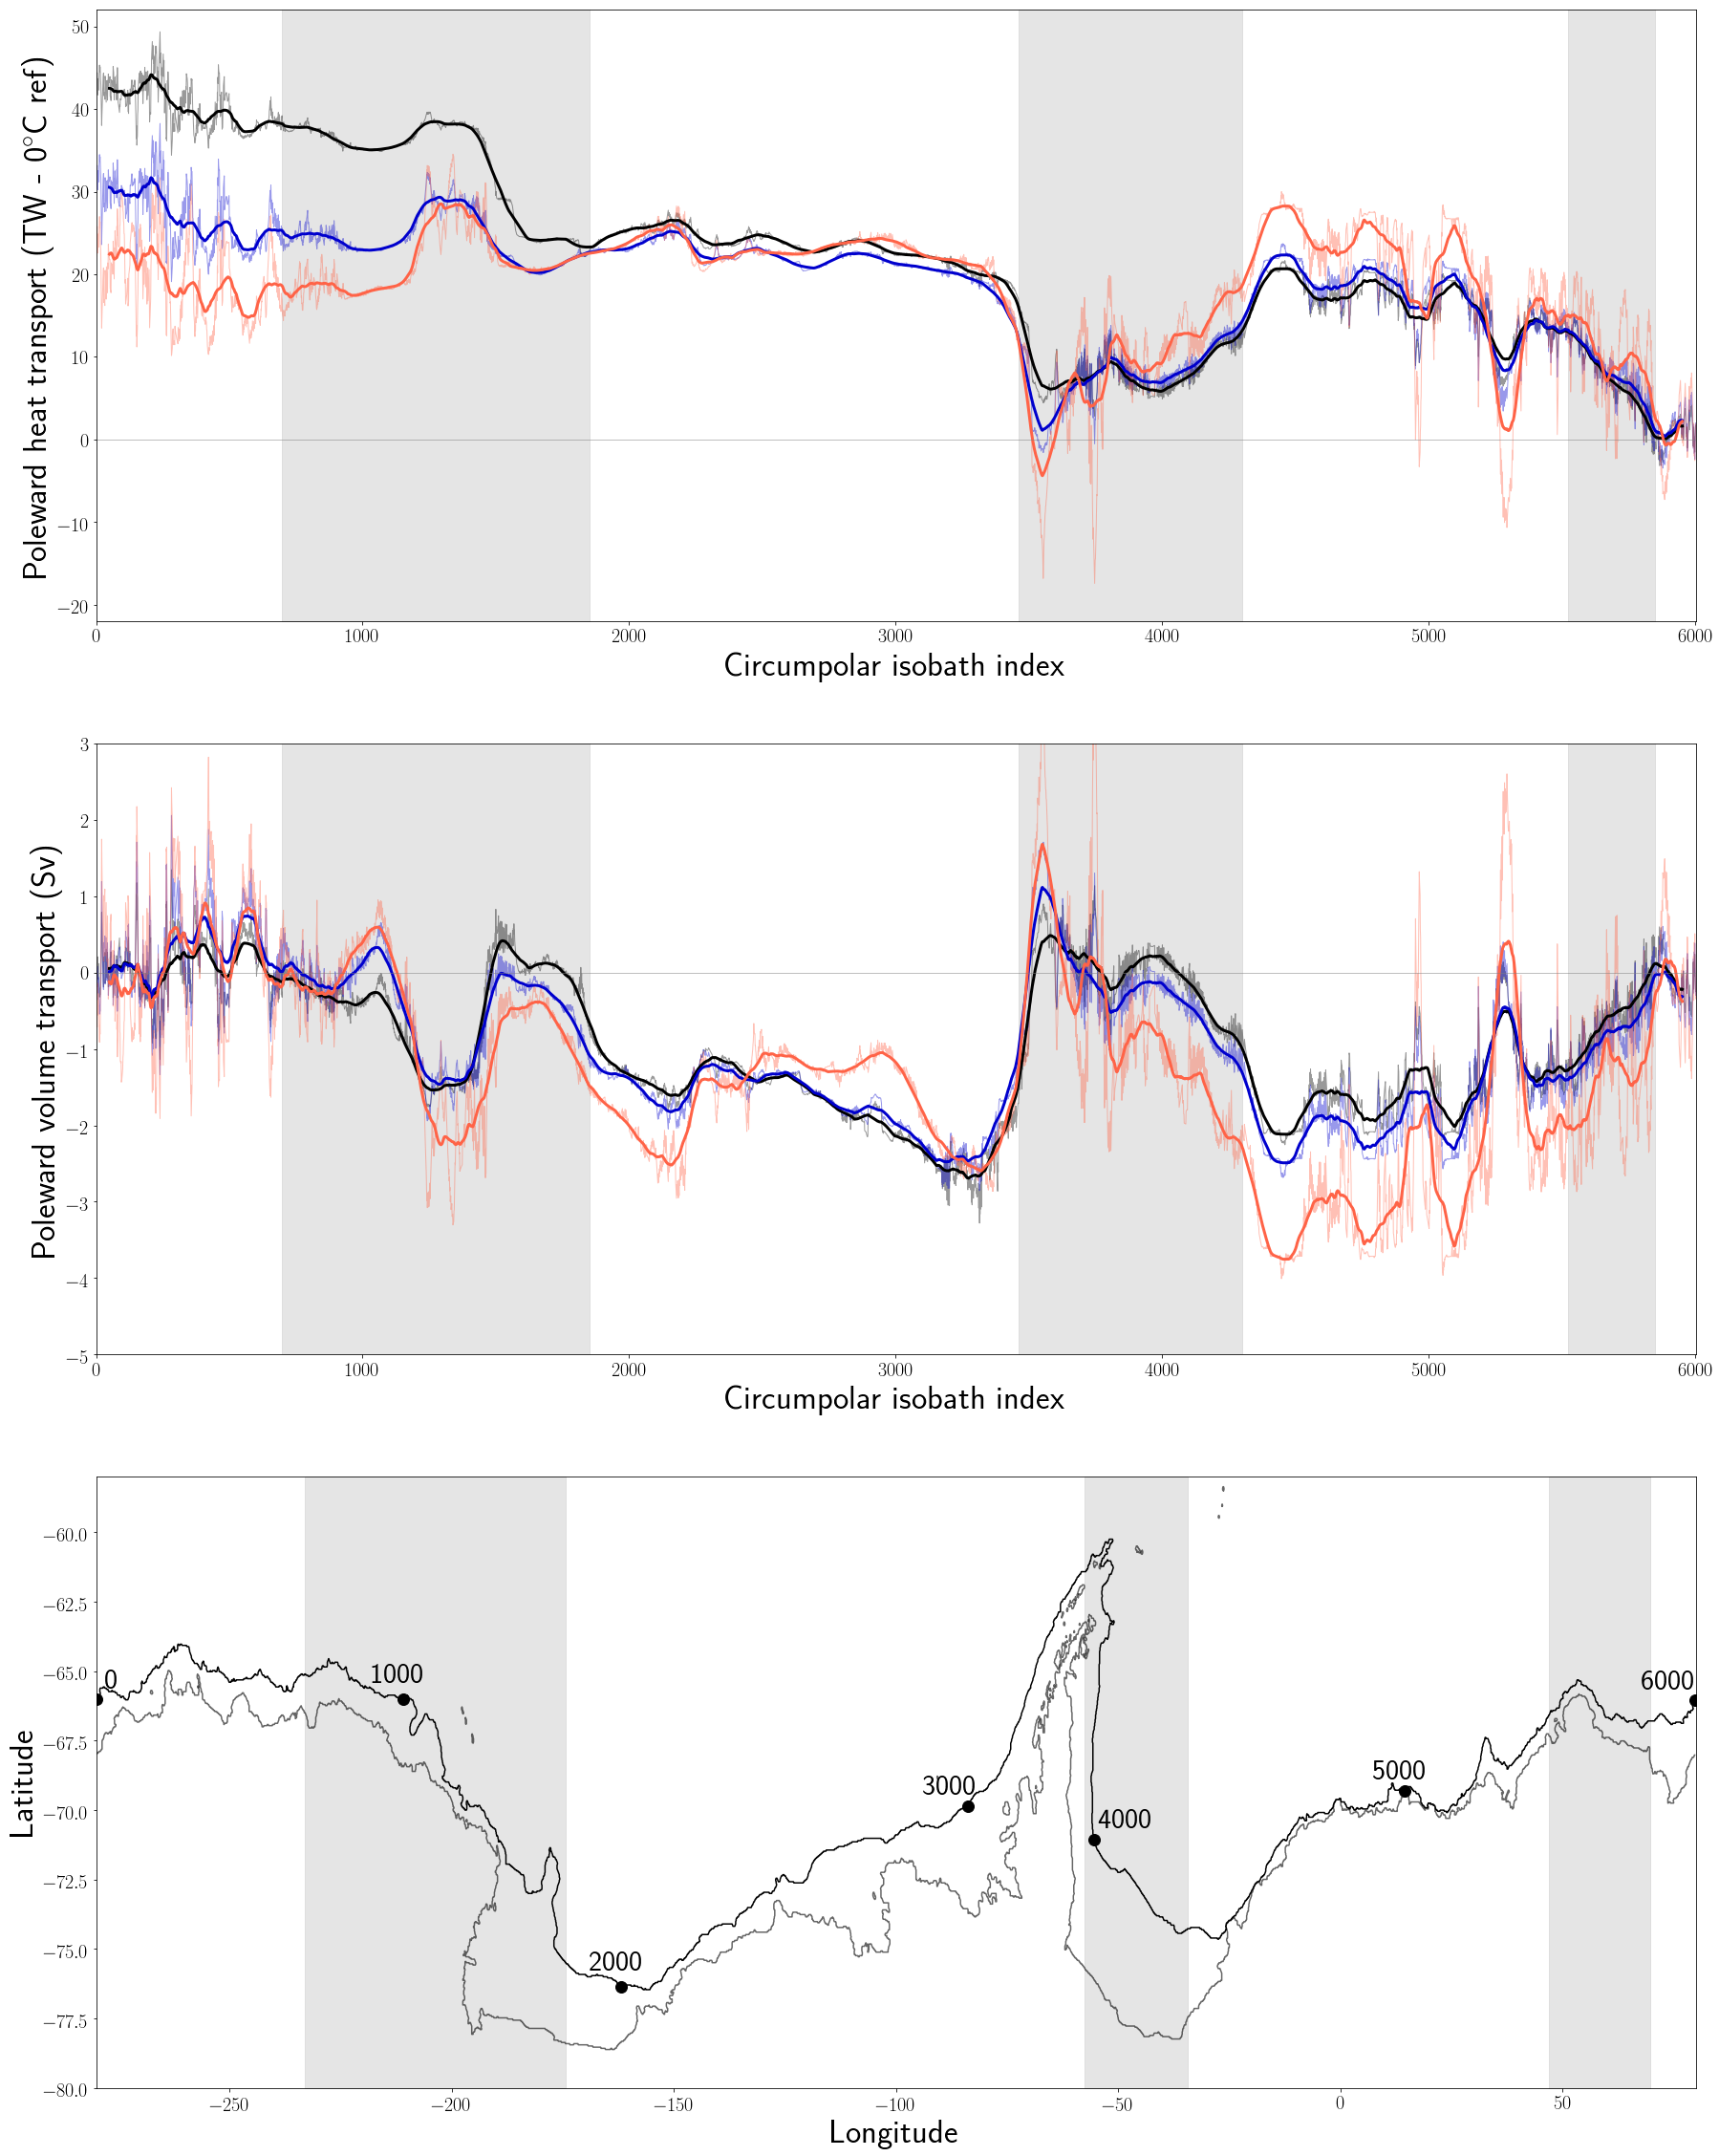

In [42]:
fig = plt.figure(num=1,figsize=(30,40))
gs = gridspec.GridSpec(3,1) 
ax,ax0,ax1 =  plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2])

rcp45_smooth = smoothed100_rcp45_0C_backwards_full
rcp85_smooth = smoothed100_rcp85_0C_backwards_full
control_smooth = smoothed100_control_0C_backwards_full
rcp45_line = rcp45_0C_backwards_full
rcp85_line = rcp85_0C_backwards_full
control_line = control_0C_backwards_full
plot_heat(control_line, rcp45_line, rcp85_line,control_smooth, rcp45_smooth, rcp85_smooth, ax)

rcp45_smooth = smoothed100_rcp45_volume_backwards_full
rcp85_smooth = smoothed100_rcp85_volume_backwards_full
control_smooth = smoothed100_control_volume_backwards_full
rcp45_line = rcp45_volume_backwards_full
rcp85_line = rcp85_volume_backwards_full
control_line = control_volume_backwards_full
plot_heat(control_line, rcp45_line, rcp85_line,control_smooth, rcp45_smooth, rcp85_smooth, ax0)
ax0.set_ylabel('Poleward volume transport (Sv)', fontsize = 35)
ax.set_ylim(-22,52)
ax0.set_ylim(-5,3)

map_plot(ax1)

figurepath = 'westward_summed_0C_vol.png'
fig.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='png',
            transparent=False, bbox_inches='tight', pad_inches=0.1,
            frameon=None)

plt.show()

## Plot fp referenced 5, 10 year

In [47]:
rcp85_fp_backwards_full_10.min()

<xarray.DataArray ()>
array(-50.964413)

In [ ]:
fig = plt.figure(num=1,figsize=(30,40))
gs = gridspec.GridSpec(3,1) 
ax,ax0,ax1 =  plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2])

rcp45_smooth = smoothed100_rcp45_fp_backwards_full_5
rcp85_smooth = smoothed100_rcp85_fp_backwards_full_5
control_smooth = smoothed100_control_fp_backwards_full
rcp45_line = rcp45_fp_backwards_full_5
rcp85_line = rcp85_fp_backwards_full_5
control_line = control_fp_backwards_full
plot_heat(control_line, rcp45_line, rcp85_line,control_smooth, rcp45_smooth, rcp85_smooth, ax)

rcp45_smooth = smoothed100_rcp45_fp_backwards_full_10
rcp85_smooth = smoothed100_rcp85_fp_backwards_full_10
control_smooth = smoothed100_control_fp_backwards_full
rcp45_line = rcp45_fp_backwards_full_10
rcp85_line = rcp85_fp_backwards_full_10
control_line = control_fp_backwards_full
plot_heat(control_line, rcp45_line, rcp85_line,control_smooth, rcp45_smooth, rcp85_smooth, ax0)
ax0.set_ylabel('Poleward volume transport (Sv)', fontsize = 35)
ax.set_ylim(-25,52)
ax0.set_ylim(-25,52)

map_plot(ax1)

# figurepath = 'westward_summed_0C_vol.png'
# fig.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',
#             orientation='portrait', papertype=None, format='png',
#             transparent=False, bbox_inches='tight', pad_inches=0.1,
#             frameon=None)

plt.show()

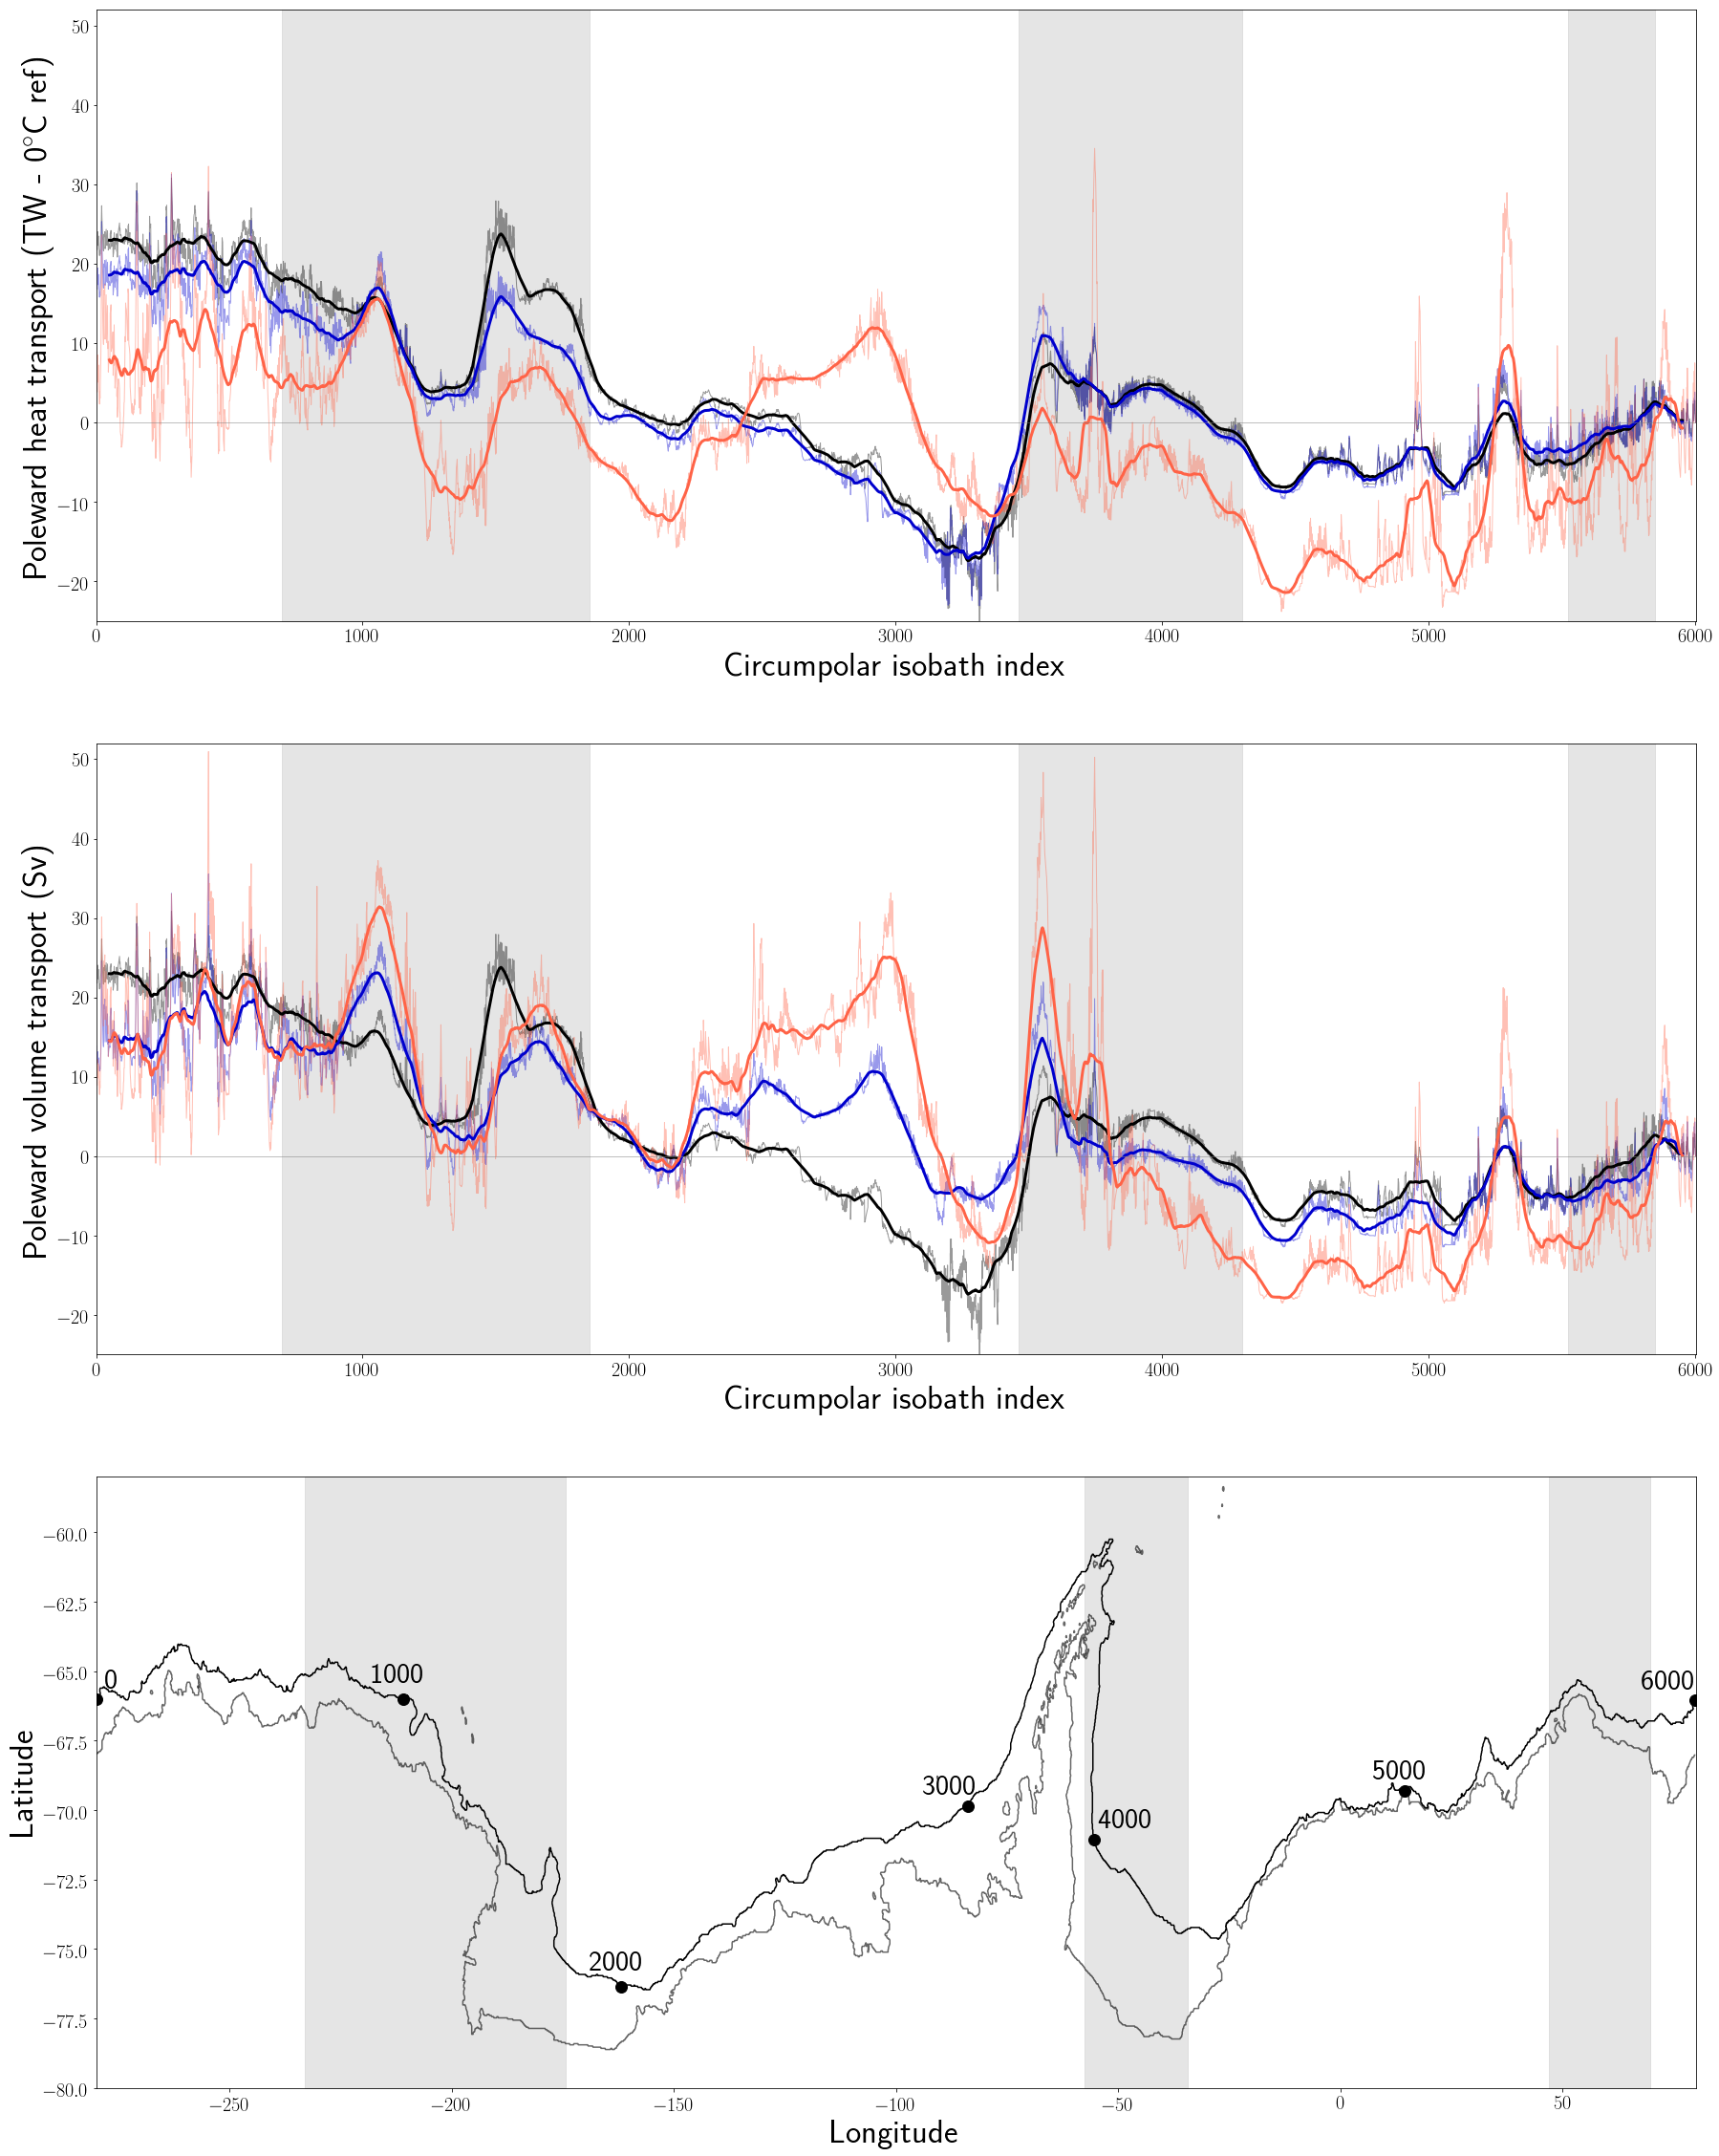

In [54]:
fig = plt.figure(num=1,figsize=(30,20))
gs = gridspec.GridSpec(3,1) 
ax,ax0,ax1 =  plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2])

rcp45_smooth = smoothed100_rcp45_fp_backwards_full_5
rcp85_smooth = smoothed100_rcp85_fp_backwards_full_5
control_smooth = smoothed100_control_fp_backwards_full
rcp45_line = rcp45_fp_backwards_full_5
rcp85_line = rcp85_fp_backwards_full_5
control_line = control_fp_backwards_full
plot_heat(control_line, rcp45_line, rcp85_line,control_smooth, rcp45_smooth, rcp85_smooth, ax)

rcp45_smooth = smoothed100_rcp45_fp_backwards_full_10
rcp85_smooth = smoothed100_rcp85_fp_backwards_full_10
control_smooth = smoothed100_control_fp_backwards_full
rcp45_line = rcp45_fp_backwards_full_10
rcp85_line = rcp85_fp_backwards_full_10
control_line = control_fp_backwards_full
plot_heat(control_line, rcp45_line, rcp85_line,control_smooth, rcp45_smooth, rcp85_smooth, ax0)
ax0.set_ylabel('Poleward volume transport (Sv)', fontsize = 35)
ax.set_ylim(-25,52)
ax0.set_ylim(-25,52)

map_plot(ax1)

# figurepath = 'westward_summed_0C_vol.png'
# fig.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',
#             orientation='portrait', papertype=None, format='png',
#             transparent=False, bbox_inches='tight', pad_inches=0.1,
#             frameon=None)

plt.show()

want to replot so all rcp45 on one plot and all rcp85 on second.

In [92]:
def plot_heat_rcp45(control_line, line5, line10,control_smooth, line5_smooth, line10_smooth, ax):
#     ax.fill_between([698,1850],[-60,-60],[60,60], color = 'silver', alpha = 0.4)
#     ax.fill_between([3460,4300],[-60,-60],[60,60], color = 'silver', alpha = 0.4)
#     ax.fill_between([5524,5850],[-60,-60],[60,60], color = 'silver', alpha = 0.4)
    ax.plot(control_line.isobath_index, control_line, color = 'k', linewidth = 1,alpha = 0.4)
    ax.plot(control_line.isobath_index, line5, color = 'mediumblue', linewidth = 1,alpha = 0.4)
    ax.plot(control_line.isobath_index, line10, color = 'purple', linewidth = 1,alpha = 0.4)
    ax.plot(control_smooth.isobath_index, control_smooth, color = 'k', linewidth = 3,label = 'Control')
    ax.plot(rcp45_smooth.isobath_index, line5_smooth, color = 'mediumblue', linewidth = 3,label = 'MW45')
    ax.plot(rcp85_smooth.isobath_index, line10_smooth, color = 'purple', linewidth =3 ,label = 'MW45')
    ax.set_ylabel('Poleward heat transport (TW - 0$^\circ$C ref)', fontsize = 35)
    ax.set_xlabel('Circumpolar isobath index', fontsize = 35)
#     ax.set_ylim((-40,50))
    ax.set_xlim((0,6002))
    ax.plot([0,6002],[0,0],'gray',linewidth=0.5)

In [90]:
def plot_heat_rcp85(control_line, line5, line10,control_smooth, line5_smooth, line10_smooth, ax):
    ax.fill_between([698,1850],[-60,-60],[100,100], color = 'silver', alpha = 0.4)
    ax.fill_between([3460,4300],[-60,-60],[100,100], color = 'silver', alpha = 0.4)
    ax.fill_between([5524,5850],[-60,-60],[100,100], color = 'silver', alpha = 0.4)
    ax.plot(control_line.isobath_index, control_line, color = 'k', linewidth = 1,alpha = 0.4)
    ax.plot(control_line.isobath_index, line5, color = 'tomato', linewidth = 1,alpha = 0.4)
    ax.plot(control_line.isobath_index, line10, color = 'red', linewidth = 1,alpha = 0.4)
    ax.plot(control_smooth.isobath_index, control_smooth, color = 'k', linewidth = 3,label = 'Control')
    ax.plot(rcp45_smooth.isobath_index, line5_smooth, color = 'tomato', linewidth = 3,label = 'MW45')
    ax.plot(rcp85_smooth.isobath_index, line10_smooth, color = 'red', linewidth =3 ,label = 'MW45')
    ax.set_ylabel('Poleward heat transport (TW - 0$^\circ$C ref)', fontsize = 35)
    ax.set_xlabel('Circumpolar isobath index', fontsize = 35)
#     ax.set_ylim((-40,50))
    ax.set_xlim((0,6002))
    ax.plot([0,6002],[0,0],'gray',linewidth=0.5)

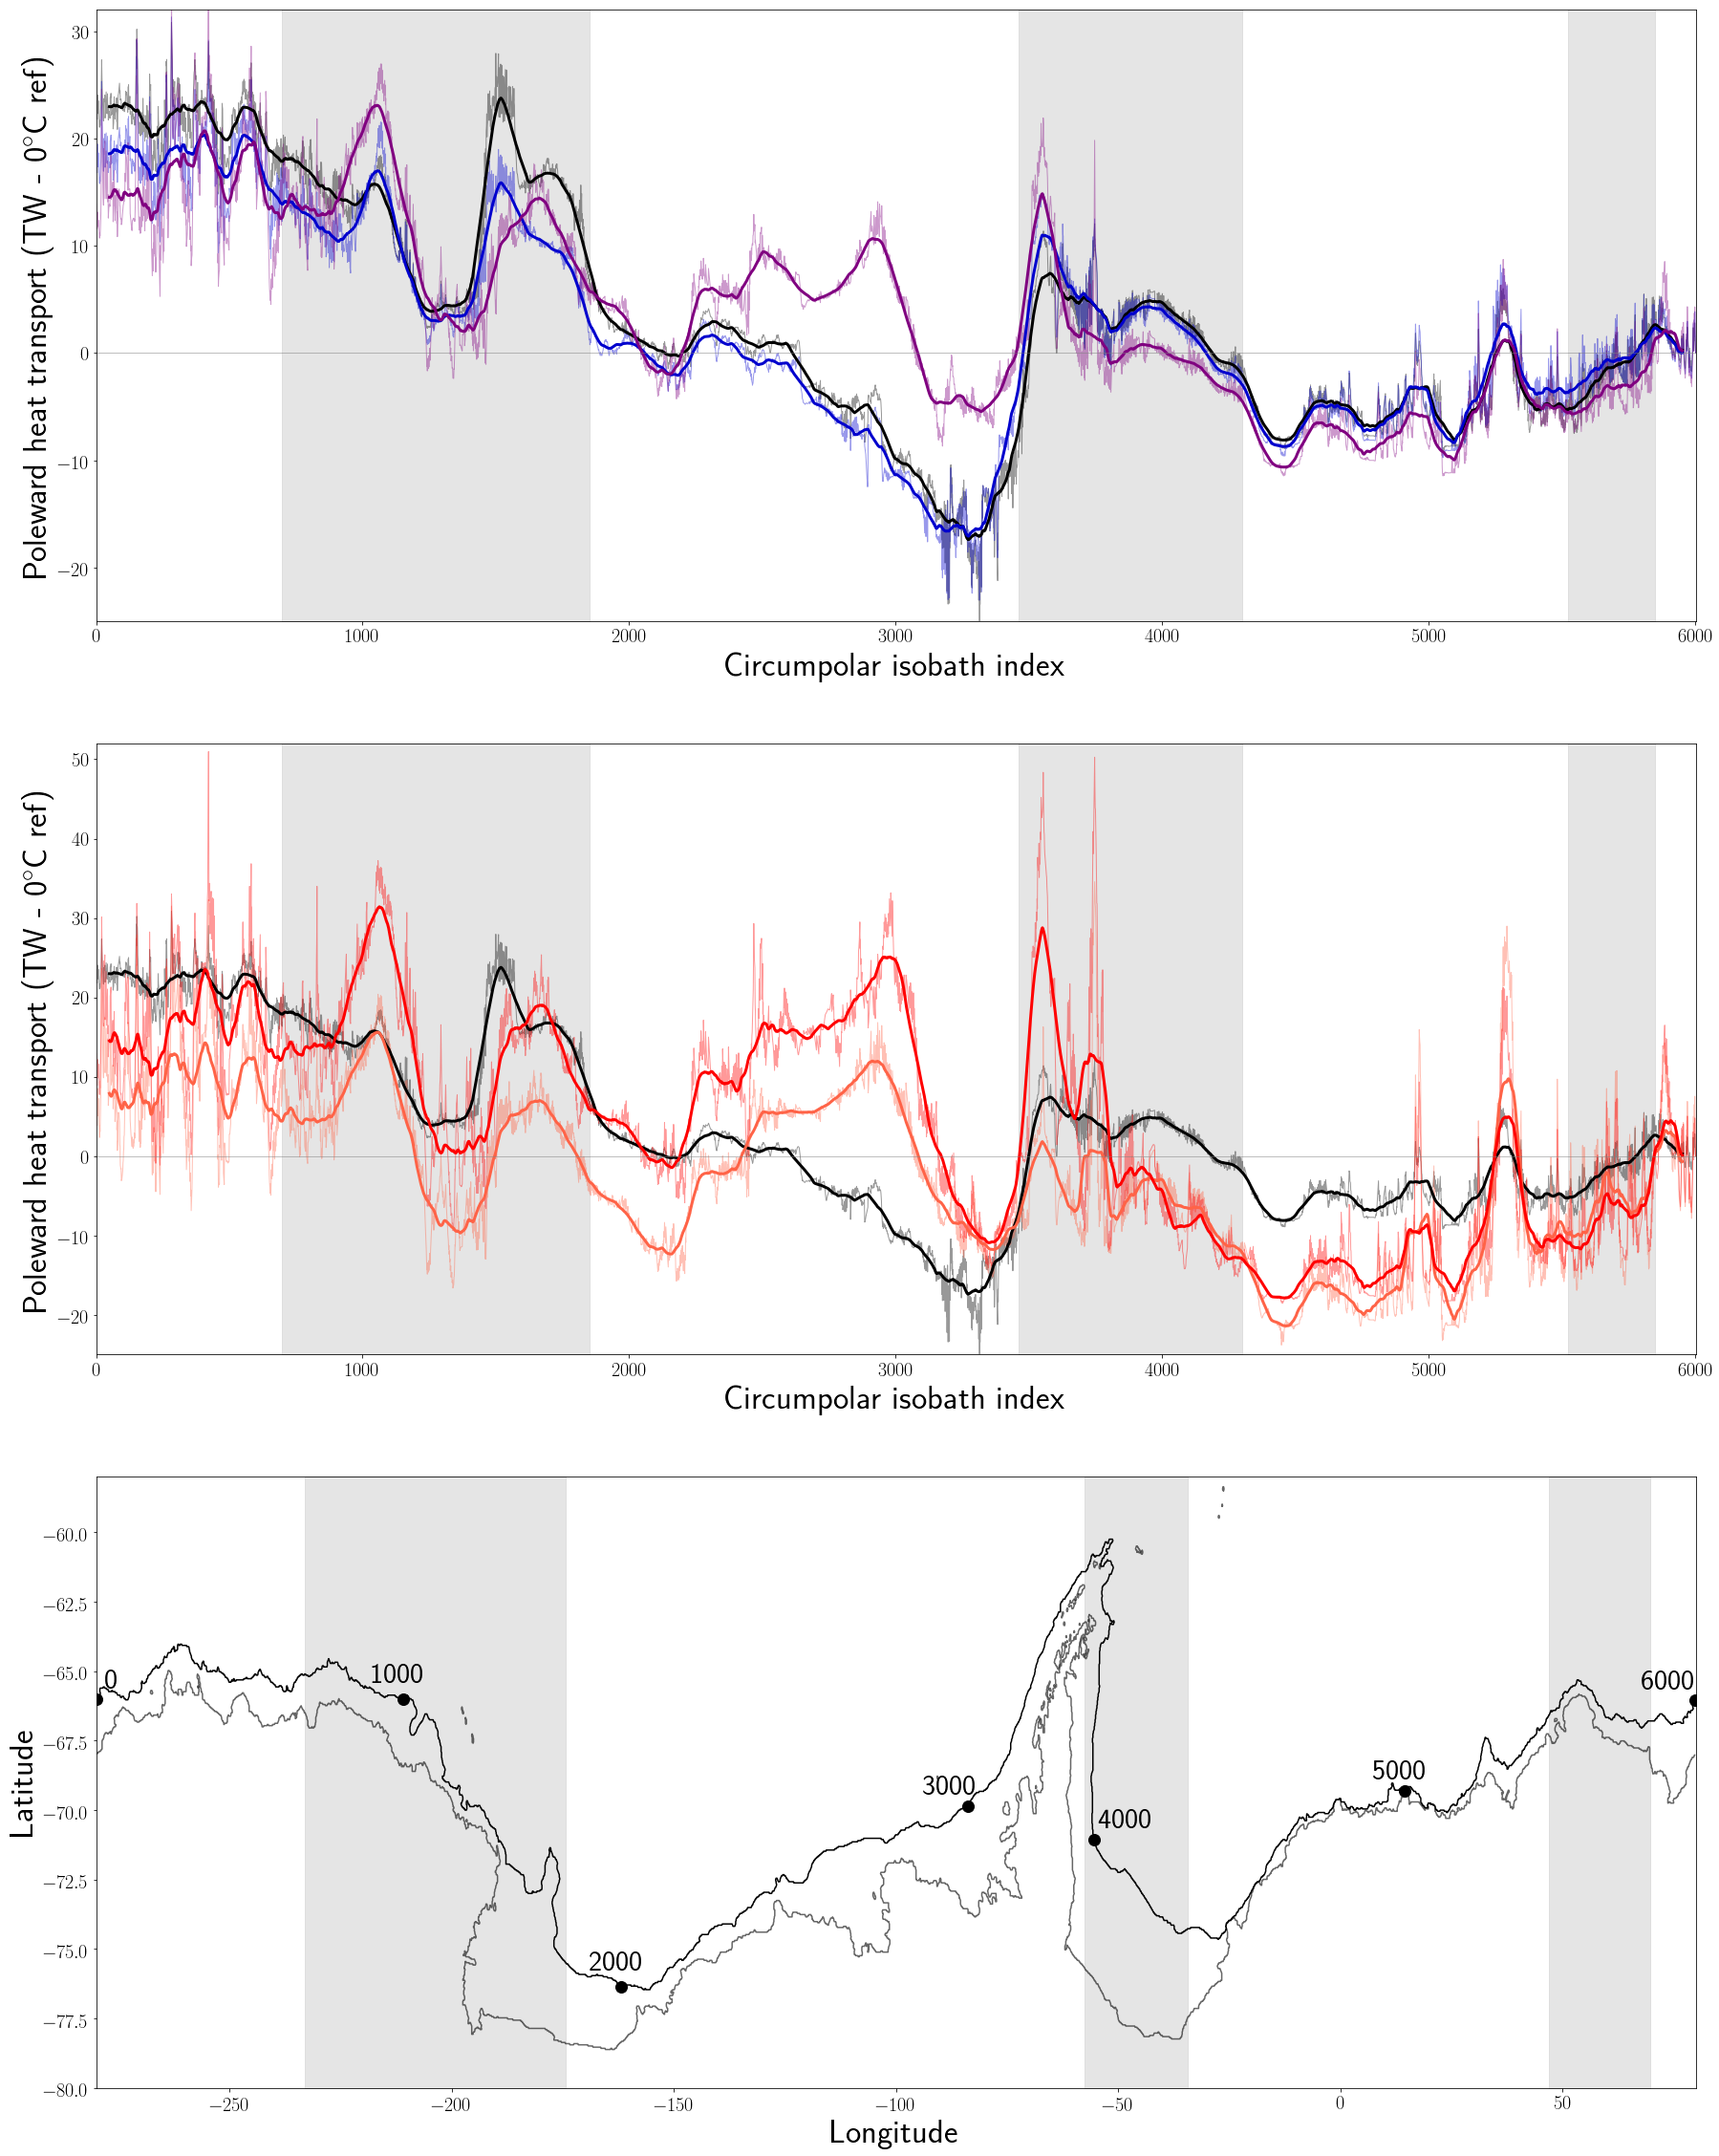

In [66]:
fig = plt.figure(num=1,figsize=(30,40))
gs = gridspec.GridSpec(3,1) 
ax,ax0,ax1 =  plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2])

line5_smooth = smoothed100_rcp45_fp_backwards_full_5
line10_smooth = smoothed100_rcp45_fp_backwards_full_10
control_smooth = smoothed100_control_fp_backwards_full
line5 = rcp45_fp_backwards_full_5
line10 = rcp45_fp_backwards_full_10
control_line = control_fp_backwards_full
plot_heat_rcp45(control_line, line5, line10,control_smooth, line5_smooth, line10_smooth, ax)

line5_smooth = smoothed100_rcp85_fp_backwards_full_5
line10_smooth = smoothed100_rcp85_fp_backwards_full_10
control_smooth = smoothed100_control_fp_backwards_full
line5 = rcp85_fp_backwards_full_5
line10 = rcp85_fp_backwards_full_10
control_line = control_fp_backwards_full
plot_heat_rcp85(control_line, line5, line10,control_smooth, line5_smooth, line10_smooth, ax0)
ax.set_ylim(-25,32)
ax0.set_ylim(-25,52)

map_plot(ax1)

# figurepath = 'westward_summed_0C_vol.png'
# fig.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',
#             orientation='portrait', papertype=None, format='png',
#             transparent=False, bbox_inches='tight', pad_inches=0.1,
#             frameon=None)

plt.show()

now I do suspect there to be some depth variation (i.e. cold waters going offshore in the deep and shallow, water waters onshore in the middepths perhaps) so lets try and distinguish that.

First attempt (same as Goddard):
RCP 4.5
700-1000m
100-700m
0-100m

In [67]:
## deep
control_fp_backwards_deep = isobath_fp_heat_flux_cumsum(control_temp_fp, control_vol_fp, slice(700,None), backwards = True)
rcp45_fp_backwards_deep_5 = isobath_fp_heat_flux_cumsum(rcp45_temp_fp_5, rcp45_vol_fp_5, slice(700,None), backwards = True)
rcp45_fp_backwards_deep_10 = isobath_fp_heat_flux_cumsum(rcp45_temp_fp_10, rcp45_vol_fp_10, slice(700,None), backwards = True)
## mid
control_fp_backwards_mid = isobath_fp_heat_flux_cumsum(control_temp_fp, control_vol_fp, slice(100,700), backwards = True)
rcp45_fp_backwards_mid_5 = isobath_fp_heat_flux_cumsum(rcp45_temp_fp_5, rcp45_vol_fp_5, slice(100,700), backwards = True)
rcp45_fp_backwards_mid_10 = isobath_fp_heat_flux_cumsum(rcp45_temp_fp_10, rcp45_vol_fp_10, slice(100,700), backwards = True)
# shallow
control_fp_backwards_shallow = isobath_fp_heat_flux_cumsum(control_temp_fp, control_vol_fp, slice(None,100), backwards = True)
rcp45_fp_backwards_shallow_5 = isobath_fp_heat_flux_cumsum(rcp45_temp_fp_5, rcp45_vol_fp_5, slice(None,100), backwards = True)
rcp45_fp_backwards_shallow_10 = isobath_fp_heat_flux_cumsum(rcp45_temp_fp_10, rcp45_vol_fp_10, slice(None,100), backwards = True)

In [68]:
smoothed100_control_fp_backwards_deep = control_fp_backwards_deep.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_rcp45_fp_backwards_deep_5 = rcp45_fp_backwards_deep_5.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_rcp45_fp_backwards_deep_10 = rcp45_fp_backwards_deep_10.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')

smoothed100_control_fp_backwards_mid = control_fp_backwards_mid.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_rcp45_fp_backwards_mid_5 = rcp45_fp_backwards_mid_5.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_rcp45_fp_backwards_mid_10 = rcp45_fp_backwards_mid_10.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')

smoothed100_control_fp_backwards_shallow = control_fp_backwards_shallow.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_rcp45_fp_backwards_shallow_5 = rcp45_fp_backwards_shallow_5.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_rcp45_fp_backwards_shallow_10 = rcp45_fp_backwards_shallow_10.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')

In [69]:
## deep
rcp85_fp_backwards_deep_5 = isobath_fp_heat_flux_cumsum(rcp85_temp_fp_5, rcp85_vol_fp_5, slice(700,None), backwards = True)
rcp85_fp_backwards_deep_10 = isobath_fp_heat_flux_cumsum(rcp85_temp_fp_10, rcp85_vol_fp_10, slice(700,None), backwards = True)
## mid
rcp85_fp_backwards_mid_5 = isobath_fp_heat_flux_cumsum(rcp85_temp_fp_5, rcp85_vol_fp_5, slice(100,700), backwards = True)
rcp85_fp_backwards_mid_10 = isobath_fp_heat_flux_cumsum(rcp85_temp_fp_10, rcp85_vol_fp_10, slice(100,700), backwards = True)
## shallow
rcp85_fp_backwards_shallow_5 = isobath_fp_heat_flux_cumsum(rcp85_temp_fp_5, rcp85_vol_fp_5, slice(None,100), backwards = True)
rcp85_fp_backwards_shallow_10 = isobath_fp_heat_flux_cumsum(rcp85_temp_fp_10, rcp85_vol_fp_10, slice(None,100), backwards = True)

In [70]:
smoothed100_rcp85_fp_backwards_deep_5 = rcp85_fp_backwards_deep_5.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_rcp85_fp_backwards_deep_10 = rcp85_fp_backwards_deep_10.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')

smoothed100_rcp85_fp_backwards_mid_5 = rcp85_fp_backwards_mid_5.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_rcp85_fp_backwards_mid_10 = rcp85_fp_backwards_mid_10.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')

smoothed100_rcp85_fp_backwards_shallow_5 = rcp85_fp_backwards_shallow_5.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_rcp85_fp_backwards_shallow_10 = rcp85_fp_backwards_shallow_10.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')

In [ ]:
def plot_heat_depth(control_line, line51, line101,control_smooth, line5_smooth1, line10_smooth1, ax):
    ax.fill_between([698,1850],[-60,-60],[100,100], color = 'silver', alpha = 0.4)
    ax.fill_between([3460,4300],[-60,-60],[100,100], color = 'silver', alpha = 0.4)
    ax.fill_between([5524,5850],[-60,-60],[100,100], color = 'silver', alpha = 0.4)
    ax.plot(control_line.isobath_index, control_line, color = 'k', linewidth = 1,alpha = 0.4)
    ax.plot(control_line.isobath_index, line5, color = 'tomato', linewidth = 1,alpha = 0.4)
    ax.plot(control_line.isobath_index, line10, color = 'red', linewidth = 1,alpha = 0.4)
    ax.plot(control_smooth.isobath_index, control_smooth, color = 'k', linewidth = 3,label = 'Control')
    ax.plot(rcp45_smooth.isobath_index, line5_smooth, color = 'tomato', linewidth = 3,label = 'MW45')
    ax.plot(rcp85_smooth.isobath_index, line10_smooth, color = 'red', linewidth =3 ,label = 'MW45')
    ax.set_ylabel('Poleward heat transport (TW - 0$^\circ$C ref)', fontsize = 35)
    ax.set_xlabel('Circumpolar isobath index', fontsize = 35)
#     ax.set_ylim((-40,50))
    ax.set_xlim((0,6002))
    ax.plot([0,6002],[0,0],'gray',linewidth=0.5)

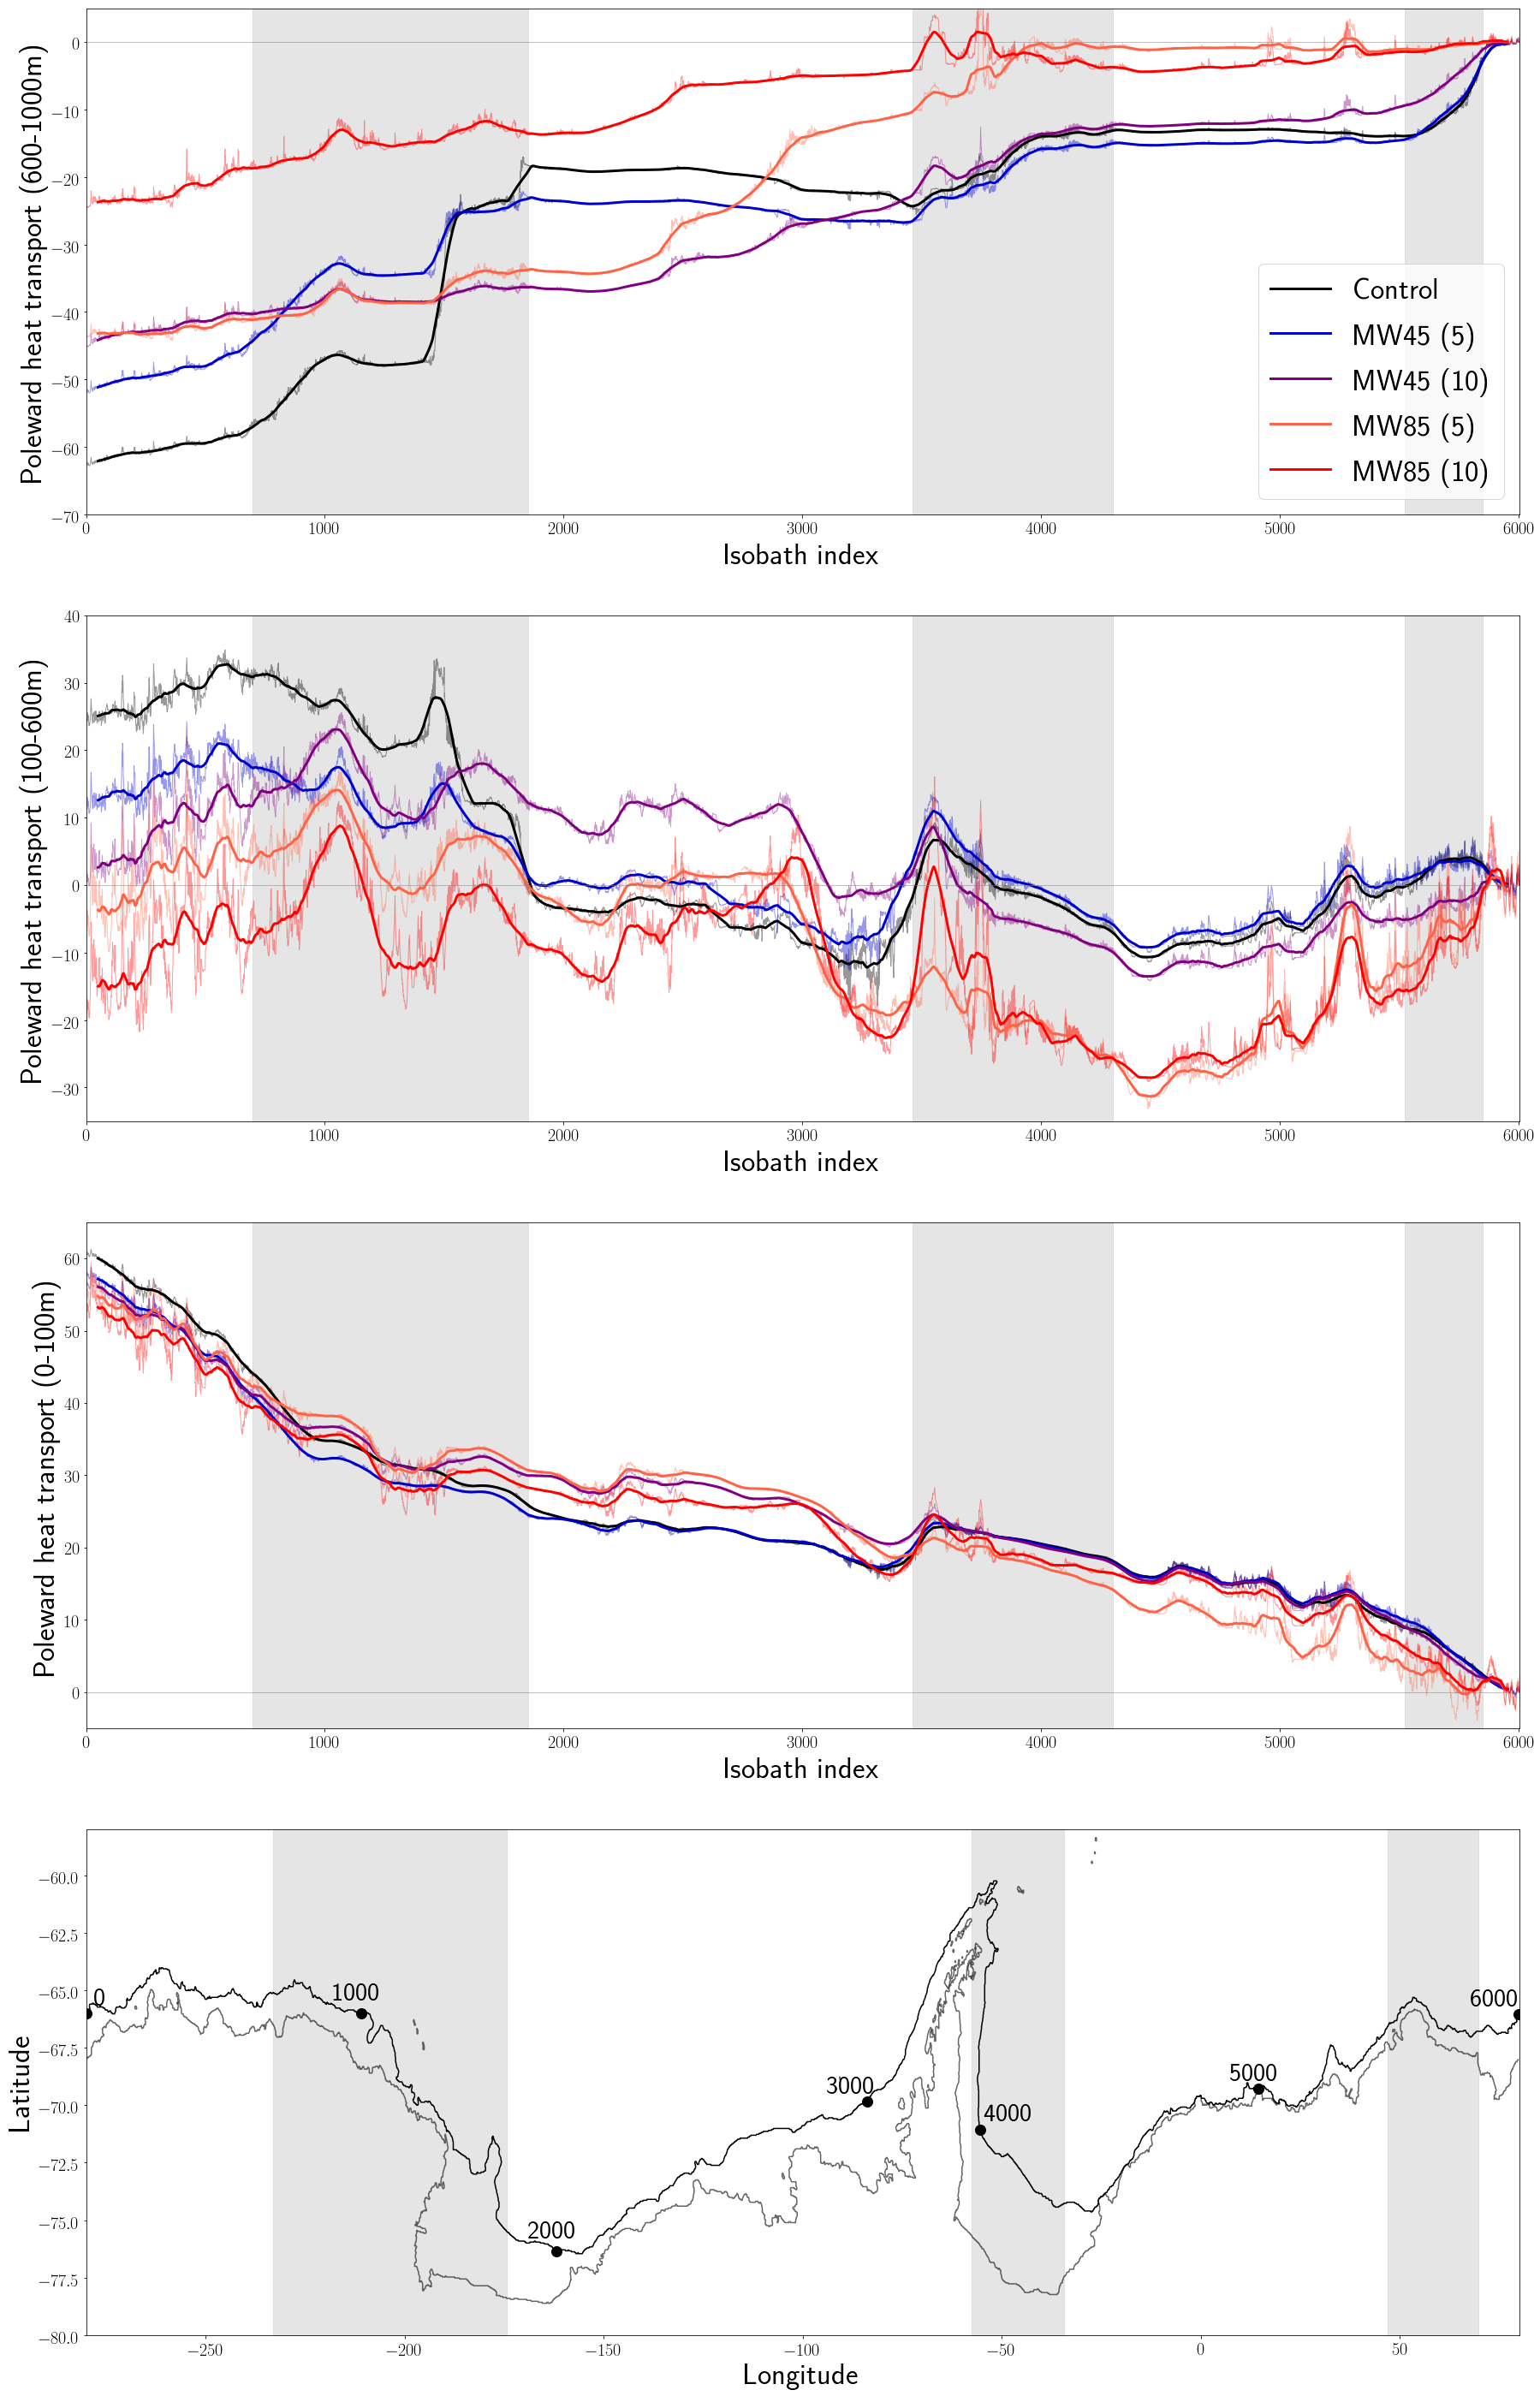

In [124]:
fig = plt.figure(num=1,figsize=(30,50))
gs = gridspec.GridSpec(4,1) 
ax,ax0,ax1, ax2 =  plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2]), plt.subplot(gs[3])


ax.fill_between([698,1850],[-100,-100],[100,100], color = 'silver', alpha = 0.4)
ax.fill_between([3460,4300],[-100,-100],[100,100], color = 'silver', alpha = 0.4)
ax.fill_between([5524,5850],[-100,-100],[100,100], color = 'silver', alpha = 0.4)
ax0.fill_between([698,1850],[-100,-100],[100,100], color = 'silver', alpha = 0.4)
ax0.fill_between([3460,4300],[-100,-100],[100,100], color = 'silver', alpha = 0.4)
ax0.fill_between([5524,5850],[-100,-100],[100,100], color = 'silver', alpha = 0.4)
ax1.fill_between([698,1850],[-100,-100],[100,100], color = 'silver', alpha = 0.4)
ax1.fill_between([3460,4300],[-100,-100],[100,100], color = 'silver', alpha = 0.4)
ax1.fill_between([5524,5850],[-100,-100],[100,100], color = 'silver', alpha = 0.4)

ax.plot(control_fp_backwards_deep.isobath_index, control_fp_backwards_deep, color = 'k', linewidth = 1,alpha = 0.4)
ax.plot(rcp45_fp_backwards_deep_5.isobath_index, rcp45_fp_backwards_deep_5, color = 'mediumblue', linewidth = 1,alpha = 0.4)
ax.plot(rcp45_fp_backwards_deep_10.isobath_index, rcp45_fp_backwards_deep_10, color = 'purple', linewidth = 1,alpha = 0.4)
ax.plot(rcp85_fp_backwards_deep_5.isobath_index, rcp85_fp_backwards_deep_5, color = 'tomato', linewidth = 1,alpha = 0.4)
ax.plot(rcp85_fp_backwards_deep_10.isobath_index, rcp85_fp_backwards_deep_10, color = 'red', linewidth = 1,alpha = 0.4)
ax.plot(smoothed100_control_fp_backwards_deep.isobath_index, smoothed100_control_fp_backwards_deep, color = 'k', linewidth = 3, label = 'Control')
ax.plot(smoothed100_rcp45_fp_backwards_deep_5.isobath_index, smoothed100_rcp45_fp_backwards_deep_5, color = 'mediumblue', linewidth = 3, label = 'MW45 (5)')
ax.plot(smoothed100_rcp45_fp_backwards_deep_10.isobath_index, smoothed100_rcp45_fp_backwards_deep_10, color = 'purple', linewidth = 3, label = 'MW45 (10)')
ax.plot(smoothed100_rcp85_fp_backwards_deep_5.isobath_index, smoothed100_rcp85_fp_backwards_deep_5, color = 'tomato', linewidth = 3, label = 'MW85 (5)')
ax.plot(smoothed100_rcp85_fp_backwards_deep_10.isobath_index, smoothed100_rcp85_fp_backwards_deep_10, color = 'red', linewidth = 3, label = 'MW85 (10)')
ax.plot([0,6002],[0,0],'gray',linewidth=0.5)
ax.set_ylabel('Poleward heat transport (600-1000m)', fontsize = 35)
ax.set_xlabel('Isobath index', fontsize = 35)
ax.legend(loc = 0, fontsize = 35)
ax.set_ylim(-70,5)
ax.set_xlim(0,6002)

ax0.plot(control_fp_backwards_mid.isobath_index, control_fp_backwards_mid, color = 'k', linewidth = 1,alpha = 0.4, label = 'Control')
ax0.plot(rcp45_fp_backwards_mid_5.isobath_index, rcp45_fp_backwards_mid_5, color = 'mediumblue', linewidth = 1,alpha = 0.4, label = 'MW45 (5)')
ax0.plot(rcp45_fp_backwards_mid_10.isobath_index, rcp45_fp_backwards_mid_10, color = 'purple', linewidth = 1,alpha = 0.4, label = 'MW45 (10)')
ax0.plot(rcp85_fp_backwards_mid_5.isobath_index, rcp85_fp_backwards_mid_5, color = 'tomato', linewidth = 1,alpha = 0.4, label = 'MW85 (5)')
ax0.plot(rcp85_fp_backwards_mid_10.isobath_index, rcp85_fp_backwards_mid_10, color = 'red', linewidth = 1,alpha = 0.4, label = 'MW85 (10)')
ax0.plot(smoothed100_control_fp_backwards_mid.isobath_index, smoothed100_control_fp_backwards_mid, color = 'k', linewidth = 3, label = 'Control')
ax0.plot(smoothed100_rcp45_fp_backwards_mid_5.isobath_index, smoothed100_rcp45_fp_backwards_mid_5, color = 'mediumblue', linewidth = 3, label = 'MW45 (5)')
ax0.plot(smoothed100_rcp45_fp_backwards_mid_10.isobath_index, smoothed100_rcp45_fp_backwards_mid_10, color = 'purple', linewidth = 3, label = 'MW45 (10)')
ax0.plot(smoothed100_rcp85_fp_backwards_mid_5.isobath_index, smoothed100_rcp85_fp_backwards_mid_5, color = 'tomato', linewidth = 3, label = 'MW85 (5)')
ax0.plot(smoothed100_rcp85_fp_backwards_mid_10.isobath_index, smoothed100_rcp85_fp_backwards_mid_10, color = 'red', linewidth = 3, label = 'MW85 (10)')
ax0.plot([0,6002],[0,0],'gray',linewidth=0.5)
ax0.set_ylabel('Poleward heat transport (100-600m)', fontsize = 35)
ax0.set_xlabel('Isobath index', fontsize = 35)
ax0.set_ylim(-35,40)
ax0.set_xlim(0,6002)


ax1.plot(control_fp_backwards_shallow.isobath_index, control_fp_backwards_shallow, color = 'k', linewidth = 1,alpha = 0.4, label = 'Control')
ax1.plot(rcp45_fp_backwards_shallow_5.isobath_index, rcp45_fp_backwards_shallow_5, color = 'mediumblue', linewidth = 1,alpha = 0.4, label = 'MW45 (5)')
ax1.plot(rcp45_fp_backwards_shallow_10.isobath_index, rcp45_fp_backwards_shallow_10, color = 'purple', linewidth = 1,alpha = 0.4, label = 'MW45 (10)')
ax1.plot(rcp85_fp_backwards_shallow_5.isobath_index, rcp85_fp_backwards_shallow_5, color = 'tomato', linewidth = 1,alpha = 0.4, label = 'MW85 (5)')
ax1.plot(rcp85_fp_backwards_shallow_10.isobath_index, rcp85_fp_backwards_shallow_10, color = 'red', linewidth = 1,alpha = 0.4, label = 'MW85 (10)')
ax1.plot(smoothed100_control_fp_backwards_shallow.isobath_index, smoothed100_control_fp_backwards_shallow, color = 'k', linewidth = 3, label = 'Control')
ax1.plot(smoothed100_rcp45_fp_backwards_shallow_5.isobath_index, smoothed100_rcp45_fp_backwards_shallow_5, color = 'mediumblue', linewidth = 3, label = 'MW45 (5)')
ax1.plot(smoothed100_rcp45_fp_backwards_shallow_10.isobath_index, smoothed100_rcp45_fp_backwards_shallow_10, color = 'purple', linewidth = 3, label = 'MW45 (10)')
ax1.plot(smoothed100_rcp85_fp_backwards_shallow_5.isobath_index, smoothed100_rcp85_fp_backwards_shallow_5, color = 'tomato', linewidth = 3, label = 'MW85 (5)')
ax1.plot(smoothed100_rcp85_fp_backwards_shallow_10.isobath_index, smoothed100_rcp85_fp_backwards_shallow_10, color = 'red', linewidth = 3, label = 'MW85 (10)')
ax1.plot([0,6002],[0,0],'gray',linewidth=0.5)
ax1.set_ylabel('Poleward heat transport (0-100m)', fontsize = 35)
ax1.set_xlabel('Isobath index', fontsize = 35)
ax1.set_ylim(-5,65)
ax1.set_xlim(0,6002)

map_plot(ax2)
figurepath = 'westward_summed_depths_fp_2.png'
fig.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='png',
            transparent=False, bbox_inches='tight', pad_inches=0.1,
            frameon=None)

plt.show()

In [94]:
## deep
control_fp_backwards_deep = isobath_fp_heat_flux_cumsum(control_temp_fp, control_vol_fp, slice(700,None), backwards = True)
rcp45_fp_backwards_deep_5 = isobath_fp_heat_flux_cumsum(rcp45_temp_fp_5, rcp45_vol_fp_5, slice(700,None), backwards = True)
rcp45_fp_backwards_deep_10 = isobath_fp_heat_flux_cumsum(rcp45_temp_fp_10, rcp45_vol_fp_10, slice(700,None), backwards = True)
## mid
control_fp_backwards_mid = isobath_fp_heat_flux_cumsum(control_temp_fp, control_vol_fp, slice(200,700), backwards = True)
rcp45_fp_backwards_mid_5 = isobath_fp_heat_flux_cumsum(rcp45_temp_fp_5, rcp45_vol_fp_5, slice(200,700), backwards = True)
rcp45_fp_backwards_mid_10 = isobath_fp_heat_flux_cumsum(rcp45_temp_fp_10, rcp45_vol_fp_10, slice(100,700), backwards = True)
## shallow
control_fp_backwards_shallow = isobath_fp_heat_flux_cumsum(control_temp_fp, control_vol_fp, slice(None,200), backwards = True)
rcp45_fp_backwards_shallow_5 = isobath_fp_heat_flux_cumsum(rcp45_temp_fp_5, rcp45_vol_fp_5, slice(None,200), backwards = True)
rcp45_fp_backwards_shallow_10 = isobath_fp_heat_flux_cumsum(rcp45_temp_fp_10, rcp45_vol_fp_10, slice(None,200), backwards = True)

In [95]:
smoothed100_control_fp_backwards_deep = control_fp_backwards_deep.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_rcp45_fp_backwards_deep_5 = rcp45_fp_backwards_deep_5.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_rcp45_fp_backwards_deep_10 = rcp45_fp_backwards_deep_10.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')

smoothed100_control_fp_backwards_mid = control_fp_backwards_mid.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_rcp45_fp_backwards_mid_5 = rcp45_fp_backwards_mid_5.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_rcp45_fp_backwards_mid_10 = rcp45_fp_backwards_mid_10.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')

smoothed100_control_fp_backwards_shallow = control_fp_backwards_shallow.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_rcp45_fp_backwards_shallow_5 = rcp45_fp_backwards_shallow_5.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_rcp45_fp_backwards_shallow_10 = rcp45_fp_backwards_shallow_10.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')

In [96]:
## deep
rcp85_fp_backwards_deep_5 = isobath_fp_heat_flux_cumsum(rcp85_temp_fp_5, rcp85_vol_fp_5, slice(700,None), backwards = True)
rcp85_fp_backwards_deep_10 = isobath_fp_heat_flux_cumsum(rcp85_temp_fp_10, rcp85_vol_fp_10, slice(700,None), backwards = True)
## mid
rcp85_fp_backwards_mid_5 = isobath_fp_heat_flux_cumsum(rcp85_temp_fp_5, rcp85_vol_fp_5, slice(200,700), backwards = True)
rcp85_fp_backwards_mid_10 = isobath_fp_heat_flux_cumsum(rcp85_temp_fp_10, rcp85_vol_fp_10, slice(200,700), backwards = True)
## shallow
rcp85_fp_backwards_shallow_5 = isobath_fp_heat_flux_cumsum(rcp85_temp_fp_5, rcp85_vol_fp_5, slice(None,200), backwards = True)
rcp85_fp_backwards_shallow_10 = isobath_fp_heat_flux_cumsum(rcp85_temp_fp_10, rcp85_vol_fp_10, slice(None,200), backwards = True)

In [97]:
smoothed100_rcp85_fp_backwards_deep_5 = rcp85_fp_backwards_deep_5.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_rcp85_fp_backwards_deep_10 = rcp85_fp_backwards_deep_10.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')

smoothed100_rcp85_fp_backwards_mid_5 = rcp85_fp_backwards_mid_5.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_rcp85_fp_backwards_mid_10 = rcp85_fp_backwards_mid_10.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')

smoothed100_rcp85_fp_backwards_shallow_5 = rcp85_fp_backwards_shallow_5.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')
smoothed100_rcp85_fp_backwards_shallow_10 = rcp85_fp_backwards_shallow_10.rolling(isobath_index = 100, center = True).mean().dropna('isobath_index')

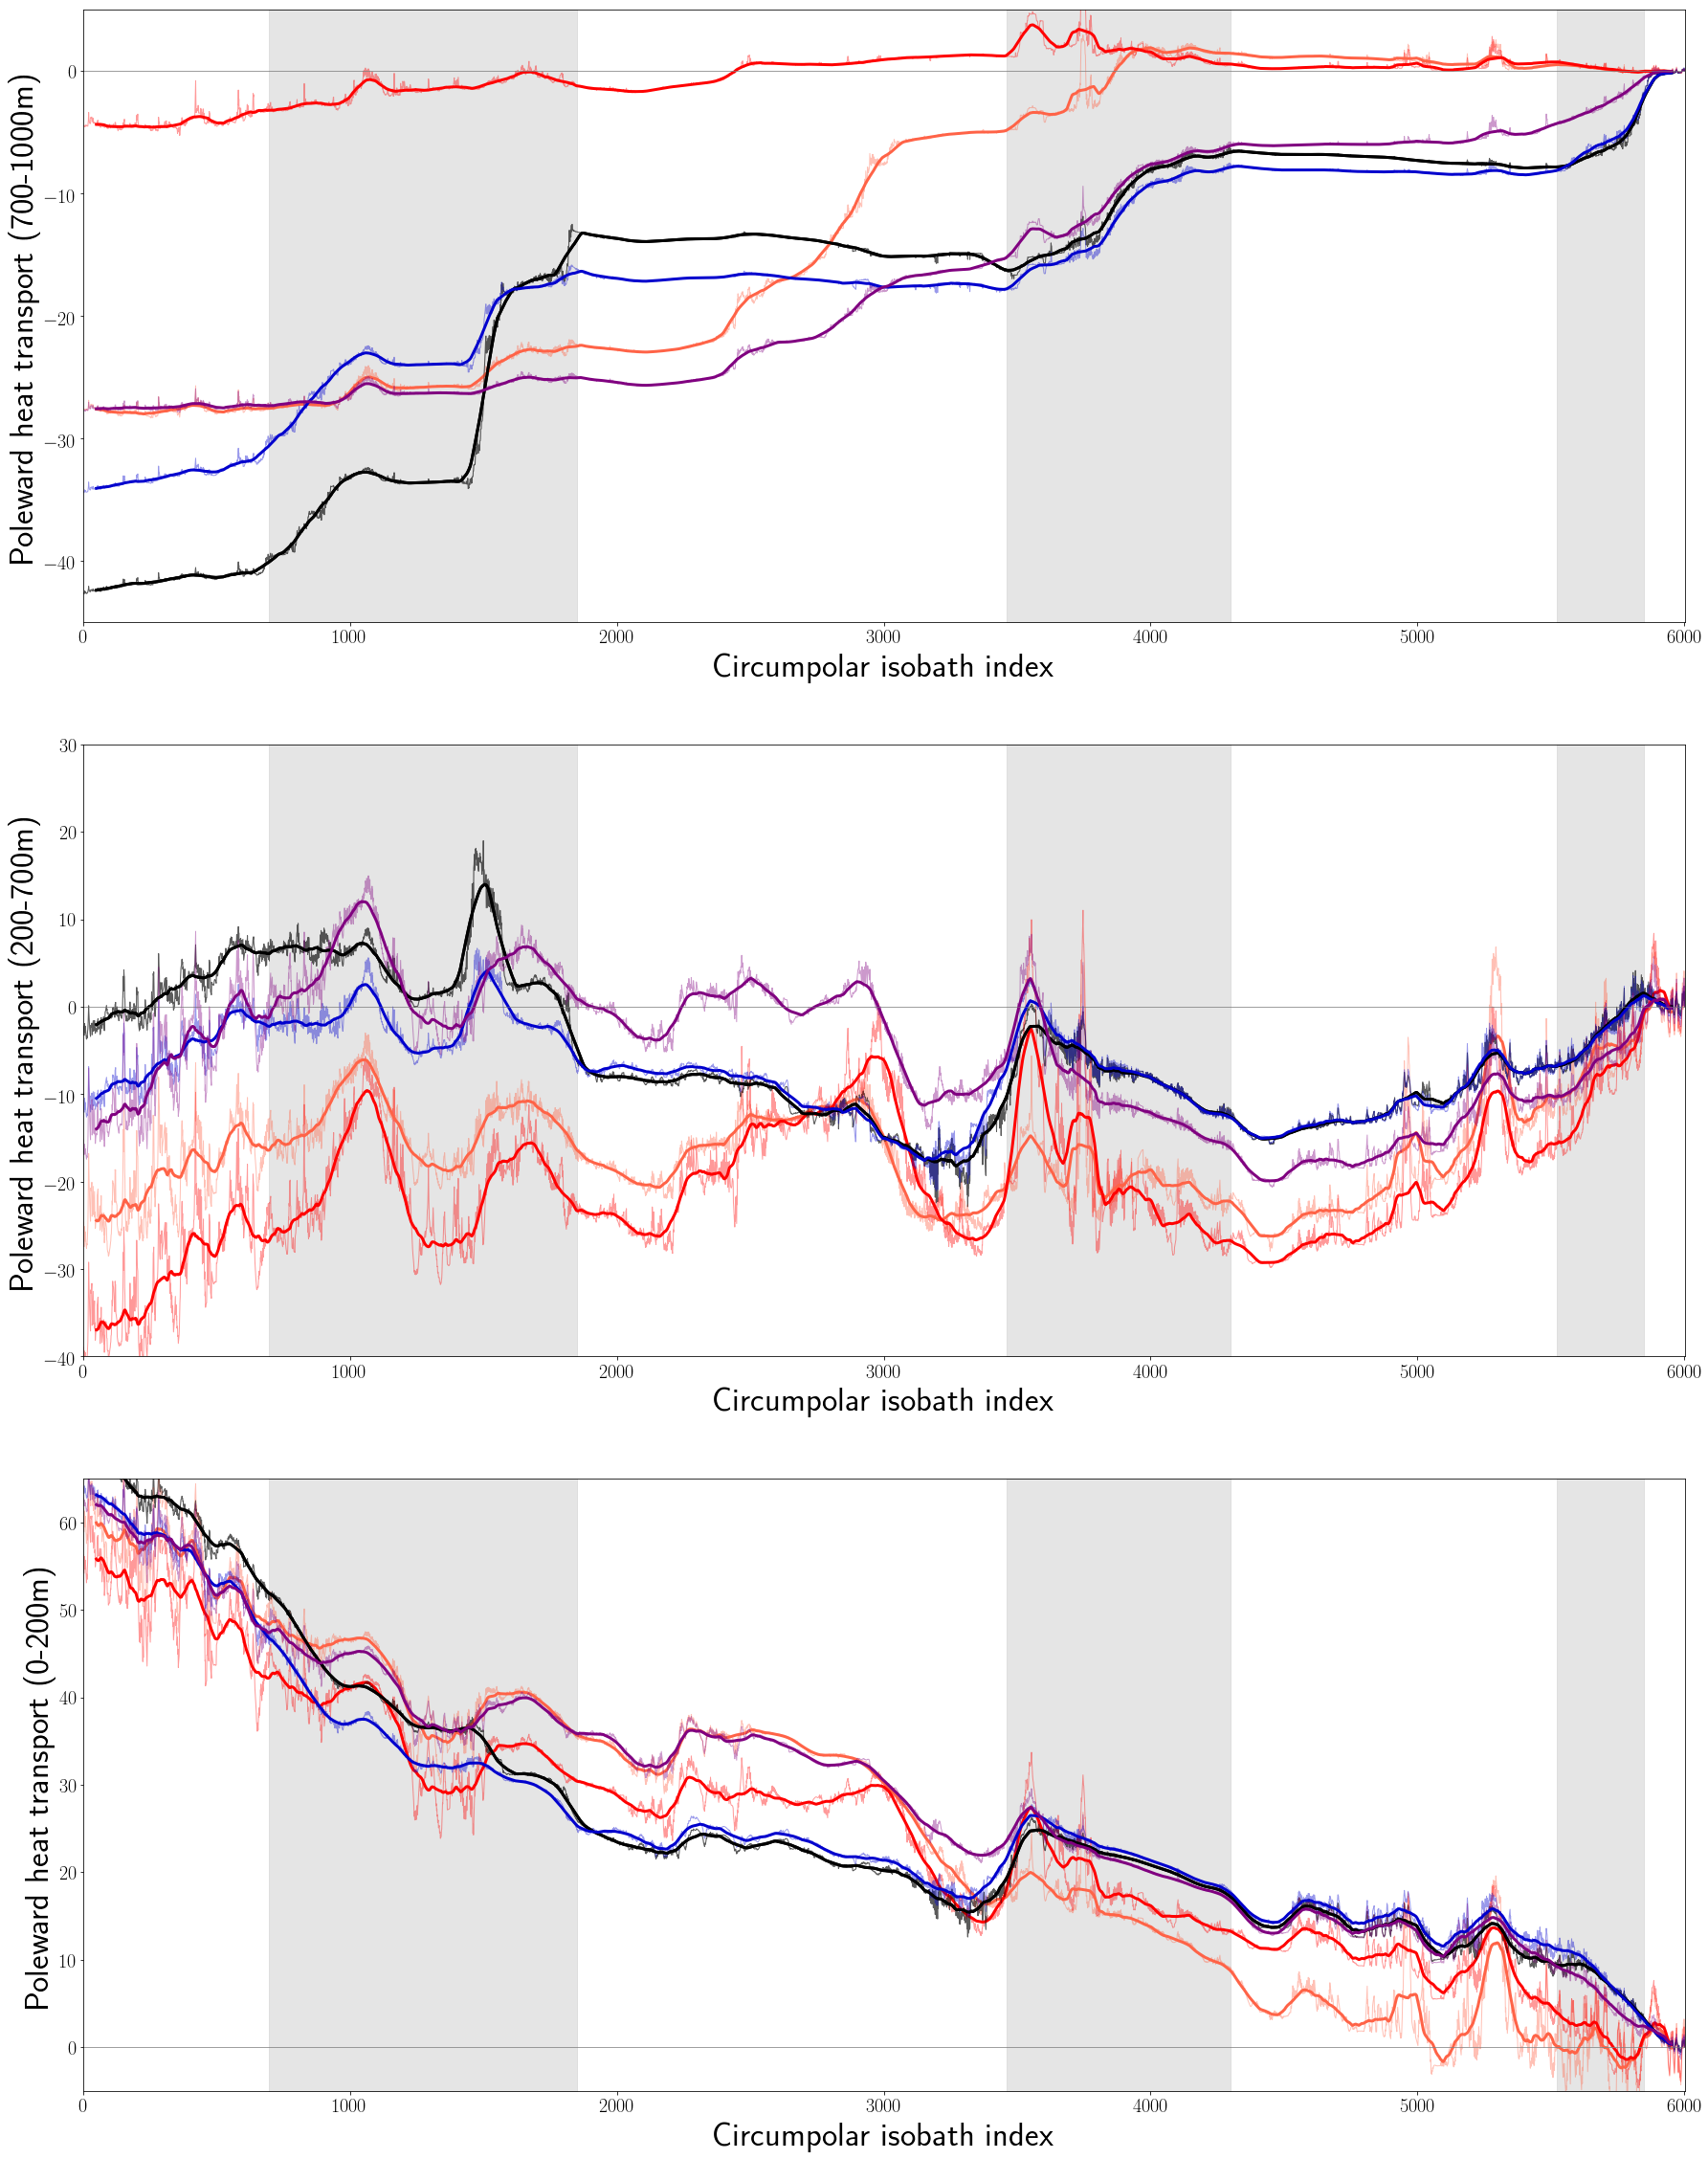

In [98]:
fig = plt.figure(num=1,figsize=(30,40))
gs = gridspec.GridSpec(3,1) 
ax,ax0,ax1 =  plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2])

line5_smooth = smoothed100_rcp85_fp_backwards_deep_5
line10_smooth = smoothed100_rcp85_fp_backwards_deep_10
control_smooth = smoothed100_control_fp_backwards_deep
line5 = rcp85_fp_backwards_deep_5
line10 = rcp85_fp_backwards_deep_10
control_line = control_fp_backwards_deep
plot_heat_rcp85(control_line, line5, line10,control_smooth, line5_smooth, line10_smooth, ax)
line5_smooth = smoothed100_rcp45_fp_backwards_deep_5
line10_smooth = smoothed100_rcp45_fp_backwards_deep_10
control_smooth = smoothed100_control_fp_backwards_deep
line5 = rcp45_fp_backwards_deep_5
line10 = rcp45_fp_backwards_deep_10
control_line = control_fp_backwards_deep
plot_heat_rcp45(control_line, line5, line10,control_smooth, line5_smooth, line10_smooth, ax)
ax.set_ylabel('Poleward heat transport (700-1000m)')
ax.set_ylim(-45,5)

line5_smooth = smoothed100_rcp85_fp_backwards_mid_5
line10_smooth = smoothed100_rcp85_fp_backwards_mid_10
control_smooth = smoothed100_control_fp_backwards_mid
line5 = rcp85_fp_backwards_mid_5
line10 = rcp85_fp_backwards_mid_10
control_line = control_fp_backwards_mid
plot_heat_rcp85(control_line, line5, line10,control_smooth, line5_smooth, line10_smooth, ax0)
line5_smooth = smoothed100_rcp45_fp_backwards_mid_5
line10_smooth = smoothed100_rcp45_fp_backwards_mid_10
control_smooth = smoothed100_control_fp_backwards_mid
line5 = rcp45_fp_backwards_mid_5
line10 = rcp45_fp_backwards_mid_10
control_line = control_fp_backwards_mid
plot_heat_rcp45(control_line, line5, line10,control_smooth, line5_smooth, line10_smooth, ax0)
ax0.set_ylabel('Poleward heat transport (200-700m)')
ax0.set_ylim(-40,30)


line5_smooth = smoothed100_rcp85_fp_backwards_shallow_5
line10_smooth = smoothed100_rcp85_fp_backwards_shallow_10
control_smooth = smoothed100_control_fp_backwards_shallow
line5 = rcp85_fp_backwards_shallow_5
line10 = rcp85_fp_backwards_shallow_10
control_line = control_fp_backwards_shallow
plot_heat_rcp85(control_line, line5, line10,control_smooth, line5_smooth, line10_smooth, ax1)
line5_smooth = smoothed100_rcp45_fp_backwards_shallow_5
line10_smooth = smoothed100_rcp45_fp_backwards_shallow_10
control_smooth = smoothed100_control_fp_backwards_shallow
line5 = rcp45_fp_backwards_shallow_5
line10 = rcp45_fp_backwards_shallow_10
control_line = control_fp_backwards_shallow
plot_heat_rcp45(control_line, line5, line10,control_smooth, line5_smooth, line10_smooth, ax1)
ax1.set_ylabel('Poleward heat transport (0-200m)')
ax1.set_ylim(-5,65)


# figurepath = 'westward_summed_0C_vol.png'
# fig.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',
#             orientation='portrait', papertype=None, format='png',
#             transparent=False, bbox_inches='tight', pad_inches=0.1,
#             frameon=None)

plt.show()

In [ ]:
control_fp_backwards_full
rcp45_fp_backwards_full_5
rcp45_fp_backwards_full_10
rcp85_fp_backwards_full_5
rcp85_fp_backwards_full_10

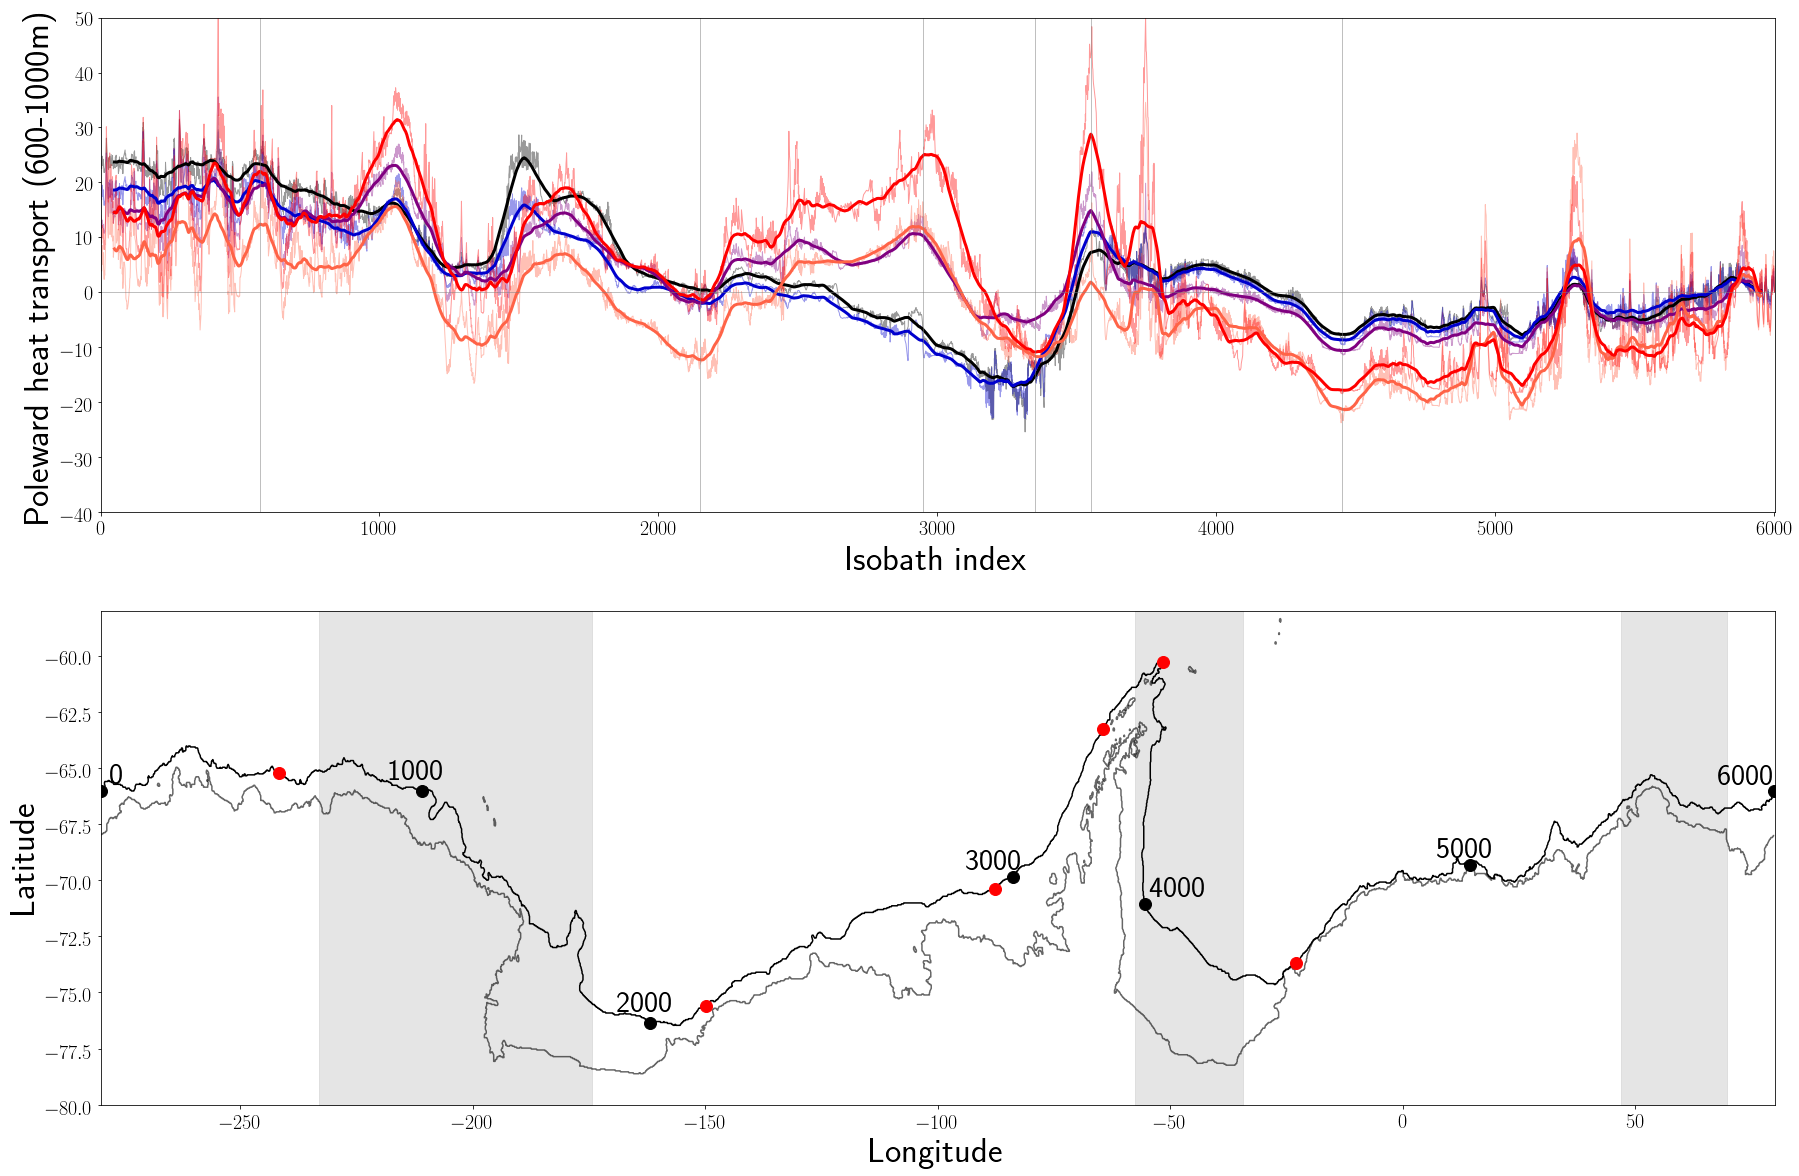

In [56]:
fig = plt.figure(num=1,figsize=(30,20))
gs = gridspec.GridSpec(2,1) 
ax,ax2 =  plt.subplot(gs[0]), plt.subplot(gs[1])

ax.plot(control_fp_backwards_full.isobath_index, control_fp_backwards_full, color = 'k', linewidth = 1,alpha = 0.4)
ax.plot(rcp45_fp_backwards_full_5.isobath_index, rcp45_fp_backwards_full_5, color = 'mediumblue', linewidth = 1,alpha = 0.4)
ax.plot(rcp45_fp_backwards_full_10.isobath_index, rcp45_fp_backwards_full_10, color = 'purple', linewidth = 1,alpha = 0.4)
ax.plot(rcp85_fp_backwards_full_5.isobath_index, rcp85_fp_backwards_full_5, color = 'tomato', linewidth = 1,alpha = 0.4)
ax.plot(rcp85_fp_backwards_full_10.isobath_index, rcp85_fp_backwards_full_10, color = 'red', linewidth = 1,alpha = 0.4)
ax.plot(smoothed100_control_fp_backwards_full.isobath_index, smoothed100_control_fp_backwards_full, color = 'k', linewidth = 3, label = 'Control')
ax.plot(smoothed100_rcp45_fp_backwards_full_5.isobath_index, smoothed100_rcp45_fp_backwards_full_5, color = 'mediumblue', linewidth = 3, label = 'MW45 (5)')
ax.plot(smoothed100_rcp45_fp_backwards_full_10.isobath_index, smoothed100_rcp45_fp_backwards_full_10, color = 'purple', linewidth = 3, label = 'MW45 (10)')
ax.plot(smoothed100_rcp85_fp_backwards_full_5.isobath_index, smoothed100_rcp85_fp_backwards_full_5, color = 'tomato', linewidth = 3, label = 'MW85 (5)')
ax.plot(smoothed100_rcp85_fp_backwards_full_10.isobath_index, smoothed100_rcp85_fp_backwards_full_10, color = 'red', linewidth = 3, label = 'MW85 (10)')
ax.plot([0,6002],[0,0],'gray',linewidth=0.5)
ax.set_ylabel('Poleward heat transport (600-1000m)', fontsize = 35)
ax.set_xlabel('Isobath index', fontsize = 35)
# ax.legend(loc = 0, fontsize = 35)



ax.plot([4450,4450],[-40,50],'gray',linewidth=0.5)
ax.plot([570,570],[-40,50],'gray',linewidth=0.5)
ax.plot([3550,3550],[-40,50],'gray',linewidth=0.5)
ax.plot([3350,3350],[-40,50],'gray',linewidth=0.5)
ax.plot([2150,2150],[-40,50],'gray',linewidth=0.5)
ax.plot([2950,2950],[-40,50],'gray',linewidth=0.5)


ax2.plot(lon_along_isobath[4450], lat_along_isobath[4450],marker='o', color='red', markersize=12)
ax2.plot(lon_along_isobath[570], lat_along_isobath[570],marker='o', color='red', markersize=12)
ax2.plot(lon_along_isobath[3550], lat_along_isobath[3550],marker='o', color='red', markersize=12)
ax2.plot(lon_along_isobath[3350], lat_along_isobath[3350],marker='o', color='red', markersize=12)
ax2.plot(lon_along_isobath[2150], lat_along_isobath[2150],marker='o', color='red', markersize=12)
ax2.plot(lon_along_isobath[2950], lat_along_isobath[2950],marker='o', color='red', markersize=12)


map_plot(ax2)

ax.set_ylim(-40,50)
ax.set_xlim(0,6002)
# ax2.set_xlim((-250,-200))
# figurepath = 'westward_summed_depths_fp_2.png'
# fig.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',
#             orientation='portrait', papertype=None, format='png',
#             transparent=False, bbox_inches='tight', pad_inches=0.1,
#             frameon=None)

plt.show()

In [93]:
print(control_fp_backwards_full.sel(isobath_index = 3550).values - control_fp_backwards_full.sel(isobath_index = 4450).values)
print(rcp45_fp_backwards_full_5.sel(isobath_index = 3550).values - rcp45_fp_backwards_full_5.sel(isobath_index = 4450).values)
print(rcp45_fp_backwards_full_10.sel(isobath_index = 3550).values - rcp45_fp_backwards_full_10.sel(isobath_index = 4450).values)
print(rcp85_fp_backwards_full_5.sel(isobath_index = 3550).values - rcp85_fp_backwards_full_5.sel(isobath_index = 4450).values)
print(rcp85_fp_backwards_full_10.sel(isobath_index = 3550).values - rcp85_fp_backwards_full_10.sel(isobath_index = 4450).values)

19.40739001447918
23.8992956736053
30.432834971425052
28.80961261036147
61.39671148594172


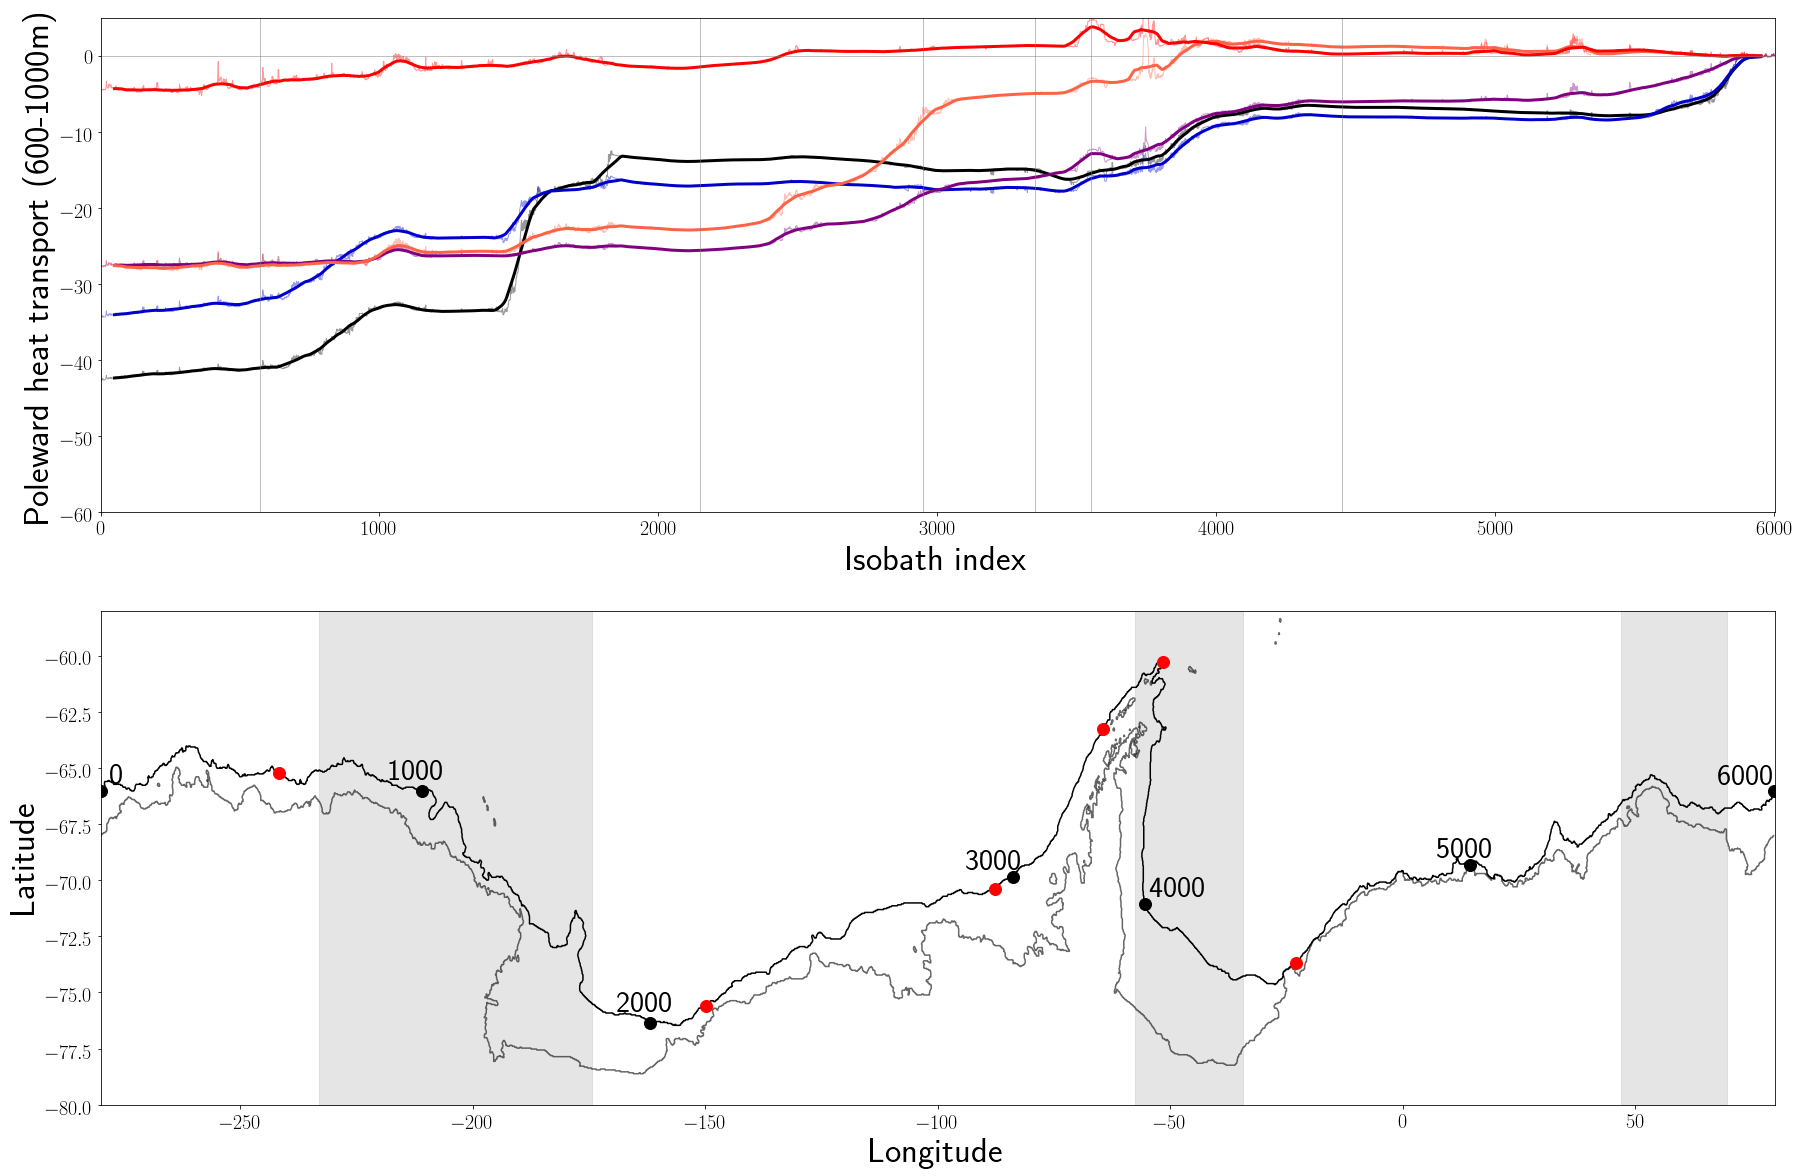

In [76]:
fig = plt.figure(num=1,figsize=(30,20))
gs = gridspec.GridSpec(2,1) 
ax,ax2 =  plt.subplot(gs[0]), plt.subplot(gs[1])

ax.plot(control_fp_backwards_deep.isobath_index, control_fp_backwards_deep, color = 'k', linewidth = 1,alpha = 0.4)
ax.plot(rcp45_fp_backwards_deep_5.isobath_index, rcp45_fp_backwards_deep_5, color = 'mediumblue', linewidth = 1,alpha = 0.4)
ax.plot(rcp45_fp_backwards_deep_10.isobath_index, rcp45_fp_backwards_deep_10, color = 'purple', linewidth = 1,alpha = 0.4)
ax.plot(rcp85_fp_backwards_deep_5.isobath_index, rcp85_fp_backwards_deep_5, color = 'tomato', linewidth = 1,alpha = 0.4)
ax.plot(rcp85_fp_backwards_deep_10.isobath_index, rcp85_fp_backwards_deep_10, color = 'red', linewidth = 1,alpha = 0.4)
ax.plot(smoothed100_control_fp_backwards_deep.isobath_index, smoothed100_control_fp_backwards_deep, color = 'k', linewidth = 3, label = 'Control')
ax.plot(smoothed100_rcp45_fp_backwards_deep_5.isobath_index, smoothed100_rcp45_fp_backwards_deep_5, color = 'mediumblue', linewidth = 3, label = 'MW45 (5)')
ax.plot(smoothed100_rcp45_fp_backwards_deep_10.isobath_index, smoothed100_rcp45_fp_backwards_deep_10, color = 'purple', linewidth = 3, label = 'MW45 (10)')
ax.plot(smoothed100_rcp85_fp_backwards_deep_5.isobath_index, smoothed100_rcp85_fp_backwards_deep_5, color = 'tomato', linewidth = 3, label = 'MW85 (5)')
ax.plot(smoothed100_rcp85_fp_backwards_deep_10.isobath_index, smoothed100_rcp85_fp_backwards_deep_10, color = 'red', linewidth = 3, label = 'MW85 (10)')
ax.plot([0,6002],[0,0],'gray',linewidth=0.5)
ax.set_ylabel('Poleward heat transport (600-1000m)', fontsize = 35)
ax.set_xlabel('Isobath index', fontsize = 35)
# ax.legend(loc = 0, fontsize = 35)



ax.plot([4450,4450],[-60,50],'gray',linewidth=0.5)
ax.plot([570,570],[-60,50],'gray',linewidth=0.5)
ax.plot([3550,3550],[-60,50],'gray',linewidth=0.5)
ax.plot([3350,3350],[-60,50],'gray',linewidth=0.5)
ax.plot([2150,2150],[-60,50],'gray',linewidth=0.5)
ax.plot([2950,2950],[-60,50],'gray',linewidth=0.5)


ax2.plot(lon_along_isobath[4450], lat_along_isobath[4450],marker='o', color='red', markersize=12)
ax2.plot(lon_along_isobath[570], lat_along_isobath[570],marker='o', color='red', markersize=12)
ax2.plot(lon_along_isobath[3550], lat_along_isobath[3550],marker='o', color='red', markersize=12)
ax2.plot(lon_along_isobath[3350], lat_along_isobath[3350],marker='o', color='red', markersize=12)
ax2.plot(lon_along_isobath[2150], lat_along_isobath[2150],marker='o', color='red', markersize=12)
ax2.plot(lon_along_isobath[2950], lat_along_isobath[2950],marker='o', color='red', markersize=12)


map_plot(ax2)

ax.set_ylim(-60,5)
ax.set_xlim(0,6002)
# ax2.set_xlim((-250,-200))
# figurepath = 'westward_summed_depths_fp_2.png'
# fig.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',
#             orientation='portrait', papertype=None, format='png',
#             transparent=False, bbox_inches='tight', pad_inches=0.1,
#             frameon=None)

plt.show()

In [94]:
print(control_fp_backwards_deep.sel(isobath_index = 2150).values - control_fp_backwards_deep.sel(isobath_index = 2950).values)
print(rcp45_fp_backwards_deep_5.sel(isobath_index = 2150).values - rcp45_fp_backwards_deep_5.sel(isobath_index = 2950).values)
print(rcp45_fp_backwards_deep_10.sel(isobath_index = 2150).values - rcp45_fp_backwards_deep_10.sel(isobath_index = 2950).values)
print(rcp85_fp_backwards_deep_5.sel(isobath_index = 2150).values - rcp85_fp_backwards_deep_5.sel(isobath_index = 2950).values)
print(rcp85_fp_backwards_deep_10.sel(isobath_index = 2150).values - rcp85_fp_backwards_deep_10.sel(isobath_index = 2950).values)

1.0871747736779298
0.46303163812862635
-7.87431103386508
-15.563769444684482
-2.233440373222905


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/distributed/client.py", line 1005, in _reconnect
    await self._close()
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.0

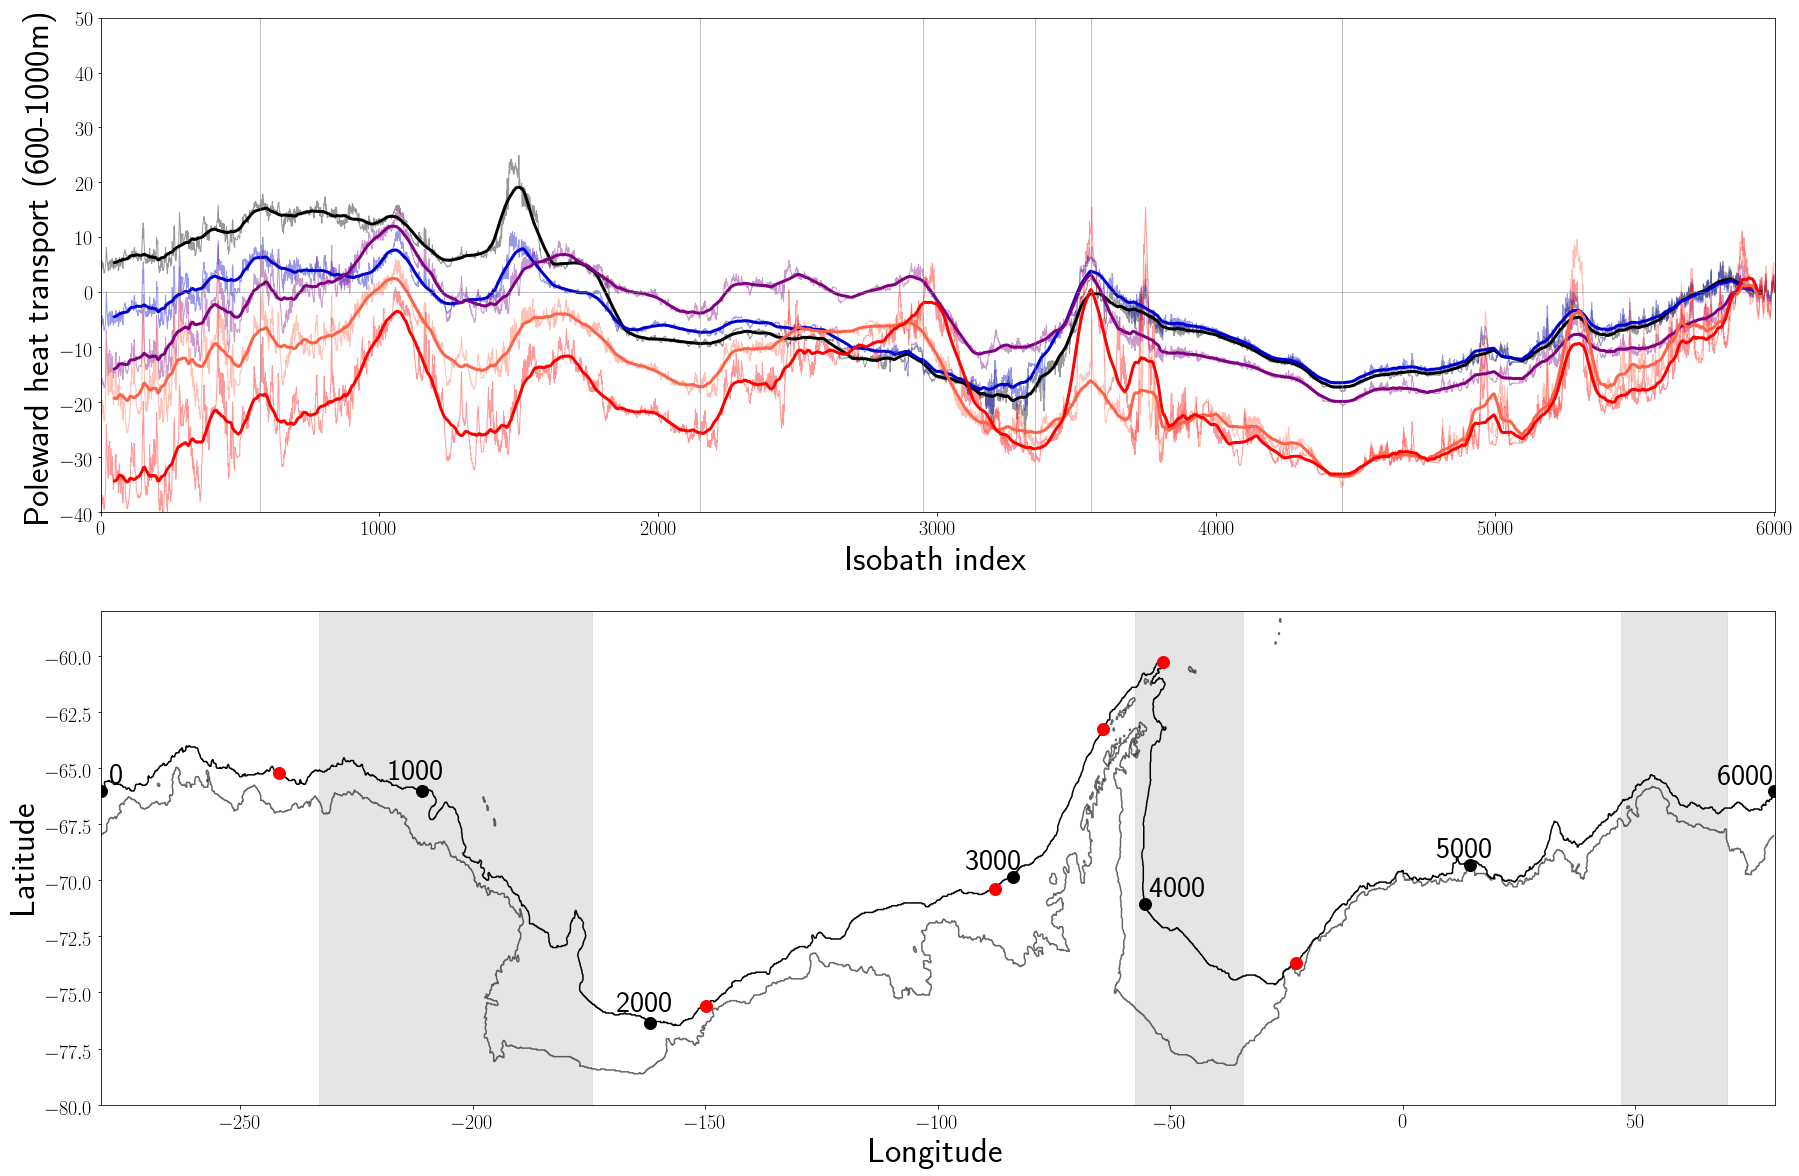

In [77]:
fig = plt.figure(num=1,figsize=(30,20))
gs = gridspec.GridSpec(2,1) 
ax,ax2 =  plt.subplot(gs[0]), plt.subplot(gs[1])

ax.plot(control_fp_backwards_mid.isobath_index, control_fp_backwards_mid, color = 'k', linewidth = 1,alpha = 0.4)
ax.plot(rcp45_fp_backwards_mid_5.isobath_index, rcp45_fp_backwards_mid_5, color = 'mediumblue', linewidth = 1,alpha = 0.4)
ax.plot(rcp45_fp_backwards_mid_10.isobath_index, rcp45_fp_backwards_mid_10, color = 'purple', linewidth = 1,alpha = 0.4)
ax.plot(rcp85_fp_backwards_mid_5.isobath_index, rcp85_fp_backwards_mid_5, color = 'tomato', linewidth = 1,alpha = 0.4)
ax.plot(rcp85_fp_backwards_mid_10.isobath_index, rcp85_fp_backwards_mid_10, color = 'red', linewidth = 1,alpha = 0.4)
ax.plot(smoothed100_control_fp_backwards_mid.isobath_index, smoothed100_control_fp_backwards_mid, color = 'k', linewidth = 3, label = 'Control')
ax.plot(smoothed100_rcp45_fp_backwards_mid_5.isobath_index, smoothed100_rcp45_fp_backwards_mid_5, color = 'mediumblue', linewidth = 3, label = 'MW45 (5)')
ax.plot(smoothed100_rcp45_fp_backwards_mid_10.isobath_index, smoothed100_rcp45_fp_backwards_mid_10, color = 'purple', linewidth = 3, label = 'MW45 (10)')
ax.plot(smoothed100_rcp85_fp_backwards_mid_5.isobath_index, smoothed100_rcp85_fp_backwards_mid_5, color = 'tomato', linewidth = 3, label = 'MW85 (5)')
ax.plot(smoothed100_rcp85_fp_backwards_mid_10.isobath_index, smoothed100_rcp85_fp_backwards_mid_10, color = 'red', linewidth = 3, label = 'MW85 (10)')
ax.plot([0,6002],[0,0],'gray',linewidth=0.5)
ax.set_ylabel('Poleward heat transport (600-1000m)', fontsize = 35)
ax.set_xlabel('Isobath index', fontsize = 35)
# ax.legend(loc = 0, fontsize = 35)



ax.plot([4450,4450],[-40,50],'gray',linewidth=0.5)
ax.plot([570,570],[-40,50],'gray',linewidth=0.5)
ax.plot([3550,3550],[-40,50],'gray',linewidth=0.5)
ax.plot([3350,3350],[-40,50],'gray',linewidth=0.5)
ax.plot([2150,2150],[-40,50],'gray',linewidth=0.5)
ax.plot([2950,2950],[-40,50],'gray',linewidth=0.5)


ax2.plot(lon_along_isobath[4450], lat_along_isobath[4450],marker='o', color='red', markersize=12)
ax2.plot(lon_along_isobath[570], lat_along_isobath[570],marker='o', color='red', markersize=12)
ax2.plot(lon_along_isobath[3550], lat_along_isobath[3550],marker='o', color='red', markersize=12)
ax2.plot(lon_along_isobath[3350], lat_along_isobath[3350],marker='o', color='red', markersize=12)
ax2.plot(lon_along_isobath[2150], lat_along_isobath[2150],marker='o', color='red', markersize=12)
ax2.plot(lon_along_isobath[2950], lat_along_isobath[2950],marker='o', color='red', markersize=12)


map_plot(ax2)

ax.set_ylim(-40,50)
ax.set_xlim(0,6002)
# ax2.set_xlim((-250,-200))
# figurepath = 'westward_summed_depths_fp_2.png'
# fig.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',
#             orientation='portrait', papertype=None, format='png',
#             transparent=False, bbox_inches='tight', pad_inches=0.1,
#             frameon=None)

plt.show()

In [88]:
print(control_fp_backwards_mid.sel(isobath_index = 570).values - control_fp_backwards_mid.sel(isobath_index = 2150).values)
print(rcp45_fp_backwards_mid_5.sel(isobath_index = 570).values - rcp45_fp_backwards_mid_5.sel(isobath_index = 2150).values)
print(rcp45_fp_backwards_mid_10.sel(isobath_index = 570).values - rcp45_fp_backwards_mid_10.sel(isobath_index = 2150).values)
print(rcp85_fp_backwards_mid_5.sel(isobath_index = 570).values - rcp85_fp_backwards_mid_5.sel(isobath_index = 2150).values)
print(rcp85_fp_backwards_mid_10.sel(isobath_index = 570).values - rcp85_fp_backwards_mid_10.sel(isobath_index = 2150).values)

24.954398176530347
14.028451804388874
5.068037057473022
10.490943247907687
6.697111433584119


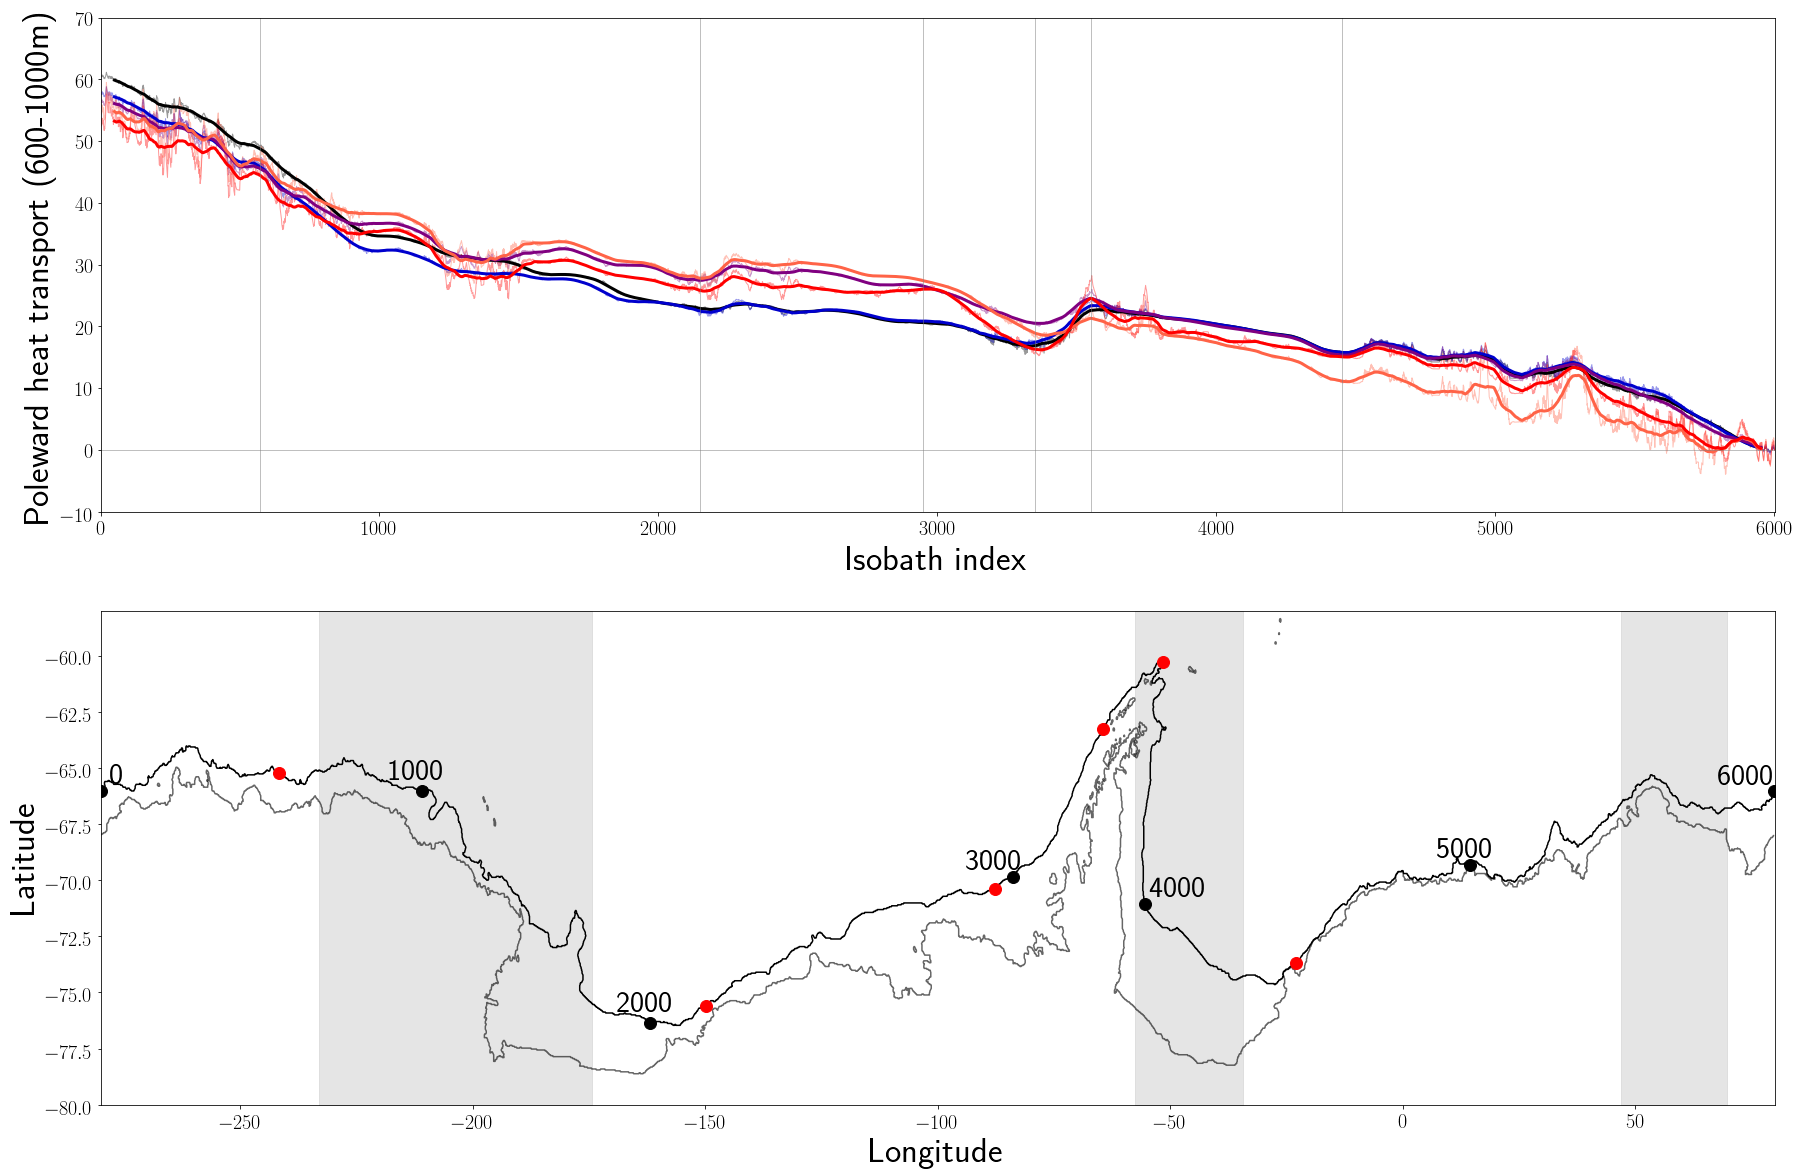

In [82]:
fig = plt.figure(num=1,figsize=(30,20))
gs = gridspec.GridSpec(2,1) 
ax,ax2 =  plt.subplot(gs[0]), plt.subplot(gs[1])

ax.plot(control_fp_backwards_shallow.isobath_index, control_fp_backwards_shallow, color = 'k', linewidth = 1,alpha = 0.4)
ax.plot(rcp45_fp_backwards_shallow_5.isobath_index, rcp45_fp_backwards_shallow_5, color = 'mediumblue', linewidth = 1,alpha = 0.4)
ax.plot(rcp45_fp_backwards_shallow_10.isobath_index, rcp45_fp_backwards_shallow_10, color = 'purple', linewidth = 1,alpha = 0.4)
ax.plot(rcp85_fp_backwards_shallow_5.isobath_index, rcp85_fp_backwards_shallow_5, color = 'tomato', linewidth = 1,alpha = 0.4)
ax.plot(rcp85_fp_backwards_shallow_10.isobath_index, rcp85_fp_backwards_shallow_10, color = 'red', linewidth = 1,alpha = 0.4)
ax.plot(smoothed100_control_fp_backwards_shallow.isobath_index, smoothed100_control_fp_backwards_shallow, color = 'k', linewidth = 3, label = 'Control')
ax.plot(smoothed100_rcp45_fp_backwards_shallow_5.isobath_index, smoothed100_rcp45_fp_backwards_shallow_5, color = 'mediumblue', linewidth = 3, label = 'MW45 (5)')
ax.plot(smoothed100_rcp45_fp_backwards_shallow_10.isobath_index, smoothed100_rcp45_fp_backwards_shallow_10, color = 'purple', linewidth = 3, label = 'MW45 (10)')
ax.plot(smoothed100_rcp85_fp_backwards_shallow_5.isobath_index, smoothed100_rcp85_fp_backwards_shallow_5, color = 'tomato', linewidth = 3, label = 'MW85 (5)')
ax.plot(smoothed100_rcp85_fp_backwards_shallow_10.isobath_index, smoothed100_rcp85_fp_backwards_shallow_10, color = 'red', linewidth = 3, label = 'MW85 (10)')
ax.plot([0,6002],[0,0],'gray',linewidth=0.5)
ax.set_ylabel('Poleward heat transport (600-1000m)', fontsize = 35)
ax.set_xlabel('Isobath index', fontsize = 35)
# ax.legend(loc = 0, fontsize = 35)



ax.plot([4450,4450],[-40,70],'gray',linewidth=0.5)
ax.plot([570,570],[-40,70],'gray',linewidth=0.5)
ax.plot([3550,3550],[-40,70],'gray',linewidth=0.5)
ax.plot([3350,3350],[-40,70],'gray',linewidth=0.5)
ax.plot([2150,2150],[-40,70],'gray',linewidth=0.5)
ax.plot([2950,2950],[-40,70],'gray',linewidth=0.5)


ax2.plot(lon_along_isobath[4450], lat_along_isobath[4450],marker='o', color='red', markersize=12)
ax2.plot(lon_along_isobath[570], lat_along_isobath[570],marker='o', color='red', markersize=12)
ax2.plot(lon_along_isobath[3550], lat_along_isobath[3550],marker='o', color='red', markersize=12)
ax2.plot(lon_along_isobath[3350], lat_along_isobath[3350],marker='o', color='red', markersize=12)
ax2.plot(lon_along_isobath[2150], lat_along_isobath[2150],marker='o', color='red', markersize=12)
ax2.plot(lon_along_isobath[2950], lat_along_isobath[2950],marker='o', color='red', markersize=12)


map_plot(ax2)

ax.set_ylim(-10,70)
ax.set_xlim(0,6002)
# ax2.set_xlim((-250,-200))
# figurepath = 'westward_summed_depths_fp_2.png'
# fig.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',
#             orientation='portrait', papertype=None, format='png',
#             transparent=False, bbox_inches='tight', pad_inches=0.1,
#             frameon=None)

plt.show()

In [89]:
print(control_fp_backwards_shallow.sel(isobath_index = 570).values - control_fp_backwards_shallow.sel(isobath_index = 2150).values)
print(rcp45_fp_backwards_shallow_5.sel(isobath_index = 570).values - rcp45_fp_backwards_shallow_5.sel(isobath_index = 2150).values)
print(rcp45_fp_backwards_shallow_10.sel(isobath_index = 570).values - rcp45_fp_backwards_shallow_10.sel(isobath_index = 2150).values)
print(rcp85_fp_backwards_shallow_5.sel(isobath_index = 570).values - rcp85_fp_backwards_shallow_5.sel(isobath_index = 2150).values)
print(rcp85_fp_backwards_shallow_10.sel(isobath_index = 570).values - rcp85_fp_backwards_shallow_10.sel(isobath_index = 2150).values)

26.605933035446817
24.336807303213213
18.700906941235175
19.6640804774107
18.94232196091398
